# Imports and setup

In [1]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics
import os
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once.

In [3]:
# Transform to apply to the minibatches for data augmentation
# Define the transformation to apply
# Transformations: Random horizontal and vertical flips, halving and doubling the brightness
# This should improve the prediction accuracy
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=[0.75, 1.25])], p=0.5)
])

class CustomDataset(Dataset):
    
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.images = os.listdir(root_dir)
        self.labels = torch.load(label_dir).long()

        # Remove the labels that do not belong to this split of the dataset (Labels is all labels)
        self.labels = self.labels[torch.tensor([int(img_name[3:9]) for img_name in self.images])]



    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        image = transform(image)
        label = self.labels[idx] # Since we removed the labels that do not belong to this split, we can use idx directly
        return image, label

# Extract the generated data
generated_data_root = "../../Data Generation/Pre Processed Data Generated"
train_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Training", generated_data_root + "/Square Images/y_generated.pt")
val_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Validation", generated_data_root + "/Square Images/y_generated.pt")
test_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Testing", generated_data_root + "/Square Images/y_generated.pt")

# Extract the real data
real_data_root = "../../Real life data/Pre processed Real Life"
train_real_dataset = CustomDataset(real_data_root + "/Square Images/Training", real_data_root + "/Square Images/y_real_life.pt")
val_real_dataset = CustomDataset(real_data_root + "/Square Images/Validation", real_data_root + "/Square Images/y_real_life.pt")
test_real_dataset = CustomDataset(real_data_root + "/Square Images/Testing", real_data_root + "/Square Images/y_real_life.pt")

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model

In [4]:
learning_rate = 0.001
batch_size_choices = {100, 200} # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == "cuda":
    torch.cuda.empty_cache()

We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

Finally, because we are using balanced accuracy scores, we can use the class analytics gathered during pre-processing to define the following class distribution array:

In [10]:
class_proportions_gen = np.array([0.3198, 0.1602, 0.0405, 0.0400, 0.0406, 0.0201, 0.0404, 0.1596, 0.0392, 0.0397, 0.0400, 0.0196, 0.0404])
class_proportions_real = np.array([0.3228, 0.1738, 0.0347, 0.0415, 0.0454, 0.0206, 0.0354, 0.1490, 0.0284, 0.0463, 0.0432, 0.0234, 0.0354])

# Print the sum of the class proportions as a sanity check
print(class_proportions_gen.sum())
print(class_proportions_real.sum())

1.0001
0.9998999999999999


 We can now proceed to defining a function that creates a data loader for both datasets, oversampling the minority classes and applying horizontal flip and blur transformations:


In [11]:
def get_gen_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_gen, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def get_real_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_real, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

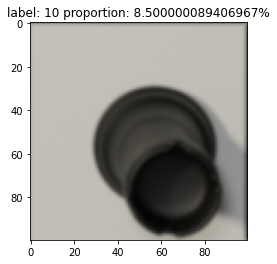

In [12]:
gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for plotting the metrics collected during training:

In [13]:
def plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    validation_x_axis = np.arange(0, len(gen_validation_losses) * n_validation, n_validation)

    plt.figure(figsize=(30, 30))

    plt.subplot(3, 2, 1)
    plt.plot(gen_training_losses)
    plt.title("Training Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")

    plt.subplot(3, 2, 2)
    plt.plot(gen_training_accs)
    plt.title("Training Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(3, 2, 3)
    plt.plot(gen_training_f1s)
    plt.title("Training weighted F1 scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 score")

    plt.subplot(3, 2, 4)
    plt.plot(validation_x_axis, gen_validation_losses, label="Source domain")
    plt.plot(validation_x_axis, real_validation_losses, label="Target domain")
    plt.title("Validation Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Focal loss")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target domain")
    plt.title("Validation Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target domain")
    plt.title("Validation weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")
    plt.legend()

    plt.suptitle("Hyperparameters: gamma: " + str(gamma) + ", batch_size: " + str(batch_size) + ", dropout_rate: " + str(dropout_rate), fontsize=24)
    
    plt.savefig("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now proceed to train our model:

In [14]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Batch size", "Dropout rate", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for batch_size in batch_size_choices:

            # Define the data loaders accounting for the batch size
            gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size)
            gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size)
            gen_test_loader = get_gen_loader(test_gen_dataset, batch_size=batch_size)
            real_train_loader = get_real_loader(train_real_dataset, batch_size=batch_size)
            real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)
            real_test_loader = get_real_loader(test_real_dataset, batch_size=batch_size)

            # Define the new loss function (Taking into account gamma)
            focal_loss = torch.hub.load(
                'adeelh/pytorch-multi-class-focal-loss',
                model='FocalLoss',
                gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
                reduction='mean',
                force_reload=False,
                verbose = False
            ).to(DEVICE)

            # To store the metrics through epochs
            gen_training_losses = []
            gen_training_accs = []
            gen_training_f1s = []
            gen_validation_losses = []
            gen_validation_accs = []
            gen_validation_f1s = []
            real_validation_losses = []
            real_validation_accs = []
            real_validation_f1s = []

            # Define the model and the optimizer
            basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)
            opt = optim.Adam(basemodel.parameters(), lr=learning_rate)
            
            for epoch in range(num_epochs):
                
                # Train the model
                for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(gen_train_loader)):
                    
                    # Set the model to training mode
                    basemodel.train()

                    # Move the data to the device
                    X_train_gen = X_train_gen.to(DEVICE)
                    y_train_gen = y_train_gen.to(DEVICE)

                    # Forward pass
                    y_train_pred_raw_gen = basemodel(X_train_gen)
                    y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

                    # Compute the loss
                    loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

                    # Compute the accuracy
                    acc_train = accuracy(y_train_pred_gen, y_train_gen)
                    f1_train = f1_score(y_train_pred_gen, y_train_gen)

                    # Backward pass
                    opt.zero_grad()
                    loss_train.backward()
                    opt.step()

                    # Store the loss & accuracy
                    gen_training_losses.append(loss_train.item())
                    gen_training_accs.append(acc_train.item())
                    gen_training_f1s.append(f1_train.item())
                    
                    # Check if the model should be validated
                    if iteration == 0 or (iteration + 1) % n_validation == 0:
                        
                        # Set the model to evaluation mode
                        basemodel.eval()
                        
                        # Disable gradient calculation
                        with torch.no_grad():

                            # 1) Evaluate on the generated validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            gen_val_iter = iter(gen_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_gen, y_val_gen = next(gen_val_iter)
                                    
                                # Move the data to the device
                                X_val_gen = X_val_gen.to(DEVICE)
                                y_val_gen = y_val_gen.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_gen = basemodel(X_val_gen)
                                y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                                weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                                loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                            # Compute the average metrics
                            acc_val_gen = acc_val_sum / n_validation_minibatches
                            loss_val_gen = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                            # 2) Repeat on the real validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            real_val_iter = iter(real_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_real, y_val_real = next(real_val_iter)
                                    
                                # Move the data to the device
                                X_val_real = X_val_real.to(DEVICE)
                                y_val_real = y_val_real.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_real = basemodel(X_val_real)
                                y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                                weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                                loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                            # Compute the average metrics
                            acc_val_real = acc_val_sum / n_validation_minibatches
                            loss_val_real = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                            # Store all 6 metrics
                            gen_validation_losses.append(loss_val_gen.item())
                            gen_validation_accs.append(acc_val_gen.item())
                            gen_validation_f1s.append(weighted_f1_val_gen.item())
                            real_validation_losses.append(loss_val_real.item())
                            real_validation_accs.append(acc_val_real.item())
                            real_validation_f1s.append(weighted_f1_val_real.item())

                            # Print an update
                            print('----------------------------------------------------------------')
                            print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                            print(f'TRAINING => Loss: {loss_train}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                            print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                            print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                            print('----------------------------------------------------------------')

                # Save the model every epoch as a checkpoint 
                torch.save(basemodel.state_dict(), f'./checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')


            # Evaluate the final real life validation accuracy

            # Set the model to evaluation mode
            basemodel.eval()
            acc_val_sum = 0

            # Create an iterator
            real_val_iter = iter(real_val_loader)

            # Disable gradient calculation
            with torch.no_grad():
                
                for i in range(n_final_validation_minibatches):

                    # Get the next minibatch
                    minibatch = next(real_val_iter, None)
                    if minibatch is None:
                        real_val_iter = iter(real_val_loader)
                        minibatch = next(real_val_iter, None)
                    X_val_real, y_val_real = minibatch

                    # Move the data to the device
                    X_val_real = X_val_real.to(DEVICE)
                    y_val_real = y_val_real.to(DEVICE)

                    # Forward pass
                    y_val_pred_prob_real = basemodel(X_val_real)
                    y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

                    # Compute the metrics
                    acc_val_sum += accuracy(y_val_pred_real, y_val_real)

            # Compute the average accuracy
            final_real_val_acc = acc_val_sum / n_final_validation_minibatches

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]

            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = basemodel
                best_acc = final_real_val_acc
                torch.save(basemodel.state_dict(), f'./best_model.ckpt')

            # Plot and save the metrics
            plot_and_save_metrics(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)


1it [00:07,  7.44s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.185088872909546, Training accuracy: 0.09999999403953552, Training weighted F1: 0.06733144819736481
GENERATED VALIDATION => Loss: 2.0822396278381348, Validation accuracy: 0.07500000298023224, Validation weighted F1: 0.014583496376872063
REAL VALIDATION => Loss: 2.1209325790405273, Validation accuracy: 0.10250000655651093, Validation weighted F1: 0.026840390637516975
----------------------------------------------------------------


10it [00:18,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.634012758731842, Training accuracy: 0.6699999570846558, Training weighted F1: 0.6224755048751831
GENERATED VALIDATION => Loss: 0.5415228605270386, Validation accuracy: 0.6324999928474426, Validation weighted F1: 0.6189817190170288
REAL VALIDATION => Loss: 1.512061357498169, Validation accuracy: 0.38499999046325684, Validation weighted F1: 0.3097272217273712
----------------------------------------------------------------


20it [00:31,  2.05s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.2920796275138855, Training accuracy: 0.8199999928474426, Training weighted F1: 0.8201672434806824
GENERATED VALIDATION => Loss: 0.22098323702812195, Validation accuracy: 0.8550000190734863, Validation weighted F1: 0.8479971885681152
REAL VALIDATION => Loss: 1.9255268573760986, Validation accuracy: 0.4074999690055847, Validation weighted F1: 0.34451770782470703
----------------------------------------------------------------


30it [00:44,  2.06s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.10184986889362335, Training accuracy: 0.9100000262260437, Training weighted F1: 0.9105114340782166
GENERATED VALIDATION => Loss: 0.09917448461055756, Validation accuracy: 0.92249995470047, Validation weighted F1: 0.9220882654190063
REAL VALIDATION => Loss: 2.1342153549194336, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.40135884284973145
----------------------------------------------------------------


40it [00:57,  2.10s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.07251967489719391, Training accuracy: 0.9350000023841858, Training weighted F1: 0.9356520175933838
GENERATED VALIDATION => Loss: 0.0642315149307251, Validation accuracy: 0.9424999952316284, Validation weighted F1: 0.9440805912017822
REAL VALIDATION => Loss: 1.9090906381607056, Validation accuracy: 0.4024999737739563, Validation weighted F1: 0.38309890031814575
----------------------------------------------------------------


50it [01:10,  2.02s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.058397501707077026, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9437161684036255
GENERATED VALIDATION => Loss: 0.04832011088728905, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9496029019355774
REAL VALIDATION => Loss: 1.4183573722839355, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.47708559036254883
----------------------------------------------------------------


60it [01:24,  2.06s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.03100254386663437, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9642605781555176
GENERATED VALIDATION => Loss: 0.04234970360994339, Validation accuracy: 0.9575000405311584, Validation weighted F1: 0.9557880759239197
REAL VALIDATION => Loss: 1.780993938446045, Validation accuracy: 0.4124999940395355, Validation weighted F1: 0.36366134881973267
----------------------------------------------------------------


70it [01:37,  2.06s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.035079240798950195, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9601665735244751
GENERATED VALIDATION => Loss: 0.0431484691798687, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9666250944137573
REAL VALIDATION => Loss: 1.4339581727981567, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.47537094354629517
----------------------------------------------------------------


80it [01:50,  1.98s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.025262577459216118, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9704737067222595
GENERATED VALIDATION => Loss: 0.03403201326727867, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699884653091431
REAL VALIDATION => Loss: 1.3987802267074585, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.46684136986732483
----------------------------------------------------------------


90it [02:03,  2.04s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.036765336990356445, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9545538425445557
GENERATED VALIDATION => Loss: 0.024559102952480316, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.97005295753479
REAL VALIDATION => Loss: 1.2621676921844482, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.49082857370376587
----------------------------------------------------------------


100it [02:16,  1.93s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.05623236671090126, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9591672420501709
GENERATED VALIDATION => Loss: 0.015288684517145157, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851046204566956
REAL VALIDATION => Loss: 1.567795753479004, Validation accuracy: 0.4775000214576721, Validation weighted F1: 0.46576353907585144
----------------------------------------------------------------


110it [02:28,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.02961454726755619, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9735507369041443
GENERATED VALIDATION => Loss: 0.012485395185649395, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849997758865356
REAL VALIDATION => Loss: 1.6234418153762817, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4339277148246765
----------------------------------------------------------------


120it [02:41,  2.07s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.022100379690527916, Training accuracy: 0.9900000095367432, Training weighted F1: 0.990055501461029
GENERATED VALIDATION => Loss: 0.010455203242599964, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876641035079956
REAL VALIDATION => Loss: 1.7364888191223145, Validation accuracy: 0.45750001072883606, Validation weighted F1: 0.4415000379085541
----------------------------------------------------------------


130it [02:55,  2.18s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.03428810462355614, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9703042507171631
GENERATED VALIDATION => Loss: 0.03145817294716835, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699718952178955
REAL VALIDATION => Loss: 1.5002102851867676, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.4712795615196228
----------------------------------------------------------------


140it [03:08,  2.01s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.023239267989993095, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9796603918075562
GENERATED VALIDATION => Loss: 0.027863912284374237, Validation accuracy: 0.9624999761581421, Validation weighted F1: 0.9619165062904358
REAL VALIDATION => Loss: 1.3536999225616455, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.4972286820411682
----------------------------------------------------------------


150it [03:19,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.023227903991937637, Training accuracy: 0.9749999642372131, Training weighted F1: 0.9750275611877441
GENERATED VALIDATION => Loss: 0.01860661804676056, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9873635768890381
REAL VALIDATION => Loss: 1.7561771869659424, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4409880042076111
----------------------------------------------------------------


160it [03:32,  1.98s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.023544808849692345, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800601005554199
GENERATED VALIDATION => Loss: 0.02185850404202938, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9822819828987122
REAL VALIDATION => Loss: 1.1030874252319336, Validation accuracy: 0.5625, Validation weighted F1: 0.5390252470970154
----------------------------------------------------------------


170it [03:45,  2.03s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.016222631558775902, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9753938317298889
GENERATED VALIDATION => Loss: 0.028292208909988403, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9825406670570374
REAL VALIDATION => Loss: 1.642042636871338, Validation accuracy: 0.45250001549720764, Validation weighted F1: 0.428808331489563
----------------------------------------------------------------


180it [03:57,  1.85s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.012541419826447964, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799598455429077
GENERATED VALIDATION => Loss: 0.010416108183562756, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.987614095211029
REAL VALIDATION => Loss: 1.5317981243133545, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.48426753282546997
----------------------------------------------------------------


190it [04:10,  1.97s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.012188894674181938, Training accuracy: 0.9900000095367432, Training weighted F1: 0.990005612373352
GENERATED VALIDATION => Loss: 0.011818279512226582, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848862290382385
REAL VALIDATION => Loss: 1.2399240732192993, Validation accuracy: 0.5424999594688416, Validation weighted F1: 0.5177568197250366
----------------------------------------------------------------


200it [04:21,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.02297801524400711, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800649285316467
GENERATED VALIDATION => Loss: 0.007774039171636105, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924361109733582
REAL VALIDATION => Loss: 1.7663518190383911, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5183743238449097
----------------------------------------------------------------


210it [04:32,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.028620338067412376, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801477789878845
GENERATED VALIDATION => Loss: 0.006150948815047741, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925636053085327
REAL VALIDATION => Loss: 1.7071311473846436, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.4880519509315491
----------------------------------------------------------------


220it [04:44,  1.85s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.020681967958807945, Training accuracy: 0.9699999690055847, Training weighted F1: 0.969959020614624
GENERATED VALIDATION => Loss: 0.016538452357053757, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851533770561218
REAL VALIDATION => Loss: 1.264143705368042, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.504335343837738
----------------------------------------------------------------


230it [04:55,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.030391892418265343, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9698970913887024
GENERATED VALIDATION => Loss: 0.023305613547563553, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.975605845451355
REAL VALIDATION => Loss: 1.4169235229492188, Validation accuracy: 0.5274999737739563, Validation weighted F1: 0.5153903961181641
----------------------------------------------------------------


240it [05:07,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.01147520076483488, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9899773001670837
GENERATED VALIDATION => Loss: 0.02345401421189308, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699828624725342
REAL VALIDATION => Loss: 1.4324575662612915, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4949786067008972
----------------------------------------------------------------


250it [05:19,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.05503665655851364, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9606401324272156
GENERATED VALIDATION => Loss: 0.0463678315281868, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9697582125663757
REAL VALIDATION => Loss: 1.5436663627624512, Validation accuracy: 0.5475000143051147, Validation weighted F1: 0.5355514287948608
----------------------------------------------------------------


260it [05:30,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.012326683849096298, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900034666061401
GENERATED VALIDATION => Loss: 0.014869130216538906, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9778451919555664
REAL VALIDATION => Loss: 1.4880387783050537, Validation accuracy: 0.48250001668930054, Validation weighted F1: 0.4583094120025635
----------------------------------------------------------------


270it [05:41,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.016151852905750275, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9803187251091003
GENERATED VALIDATION => Loss: 0.006334426812827587, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925251603126526
REAL VALIDATION => Loss: 1.580146312713623, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.47068536281585693
----------------------------------------------------------------


280it [05:53,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.005372071173042059, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950193166732788
GENERATED VALIDATION => Loss: 0.017204836010932922, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9871895909309387
REAL VALIDATION => Loss: 1.3425912857055664, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.531053900718689
----------------------------------------------------------------


290it [06:04,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.01852140761911869, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900515079498291
GENERATED VALIDATION => Loss: 0.010772870853543282, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900415539741516
REAL VALIDATION => Loss: 1.3037877082824707, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5270000696182251
----------------------------------------------------------------


300it [06:16,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.00757205905392766, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899741411209106
GENERATED VALIDATION => Loss: 0.00818752869963646, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852321743965149
REAL VALIDATION => Loss: 1.7185708284378052, Validation accuracy: 0.5225000381469727, Validation weighted F1: 0.5062682628631592
----------------------------------------------------------------


310it [06:28,  1.92s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.0032267230562865734, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00952216237783432, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849385619163513
REAL VALIDATION => Loss: 1.9624207019805908, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4792179465293884
----------------------------------------------------------------


320it [06:40,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.007153952959924936, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9853243231773376
GENERATED VALIDATION => Loss: 0.0044936444610357285, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994954526424408
REAL VALIDATION => Loss: 1.5158803462982178, Validation accuracy: 0.5625, Validation weighted F1: 0.5495142936706543
----------------------------------------------------------------


330it [06:52,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.0026868220884352922, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9949684143066406
GENERATED VALIDATION => Loss: 0.013389529660344124, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849717617034912
REAL VALIDATION => Loss: 1.597681999206543, Validation accuracy: 0.5425000190734863, Validation weighted F1: 0.5199306011199951
----------------------------------------------------------------


340it [07:04,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.0050268154591321945, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900786280632019
GENERATED VALIDATION => Loss: 0.0203469879925251, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9771608114242554
REAL VALIDATION => Loss: 1.5822484493255615, Validation accuracy: 0.5824999809265137, Validation weighted F1: 0.5795416235923767
----------------------------------------------------------------


350it [07:15,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.03460540995001793, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9644144773483276
GENERATED VALIDATION => Loss: 0.02617711015045643, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.982420027256012
REAL VALIDATION => Loss: 1.5648938417434692, Validation accuracy: 0.5750000476837158, Validation weighted F1: 0.5732483863830566
----------------------------------------------------------------


360it [07:27,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.026713328436017036, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9640244245529175
GENERATED VALIDATION => Loss: 0.010165698826313019, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.990119218826294
REAL VALIDATION => Loss: 1.6343368291854858, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5156357884407043
----------------------------------------------------------------


370it [07:39,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.00392557680606842, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.007518479600548744, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9975032210350037
REAL VALIDATION => Loss: 1.5724936723709106, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.503149151802063
----------------------------------------------------------------


380it [07:50,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.005781435873359442, Training accuracy: 0.9950000047683716, Training weighted F1: 0.994996190071106
GENERATED VALIDATION => Loss: 0.006615582853555679, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900012016296387
REAL VALIDATION => Loss: 1.5457063913345337, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.47835057973861694
----------------------------------------------------------------


390it [08:02,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.002158297225832939, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.009921408258378506, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950253367424011
REAL VALIDATION => Loss: 1.5572870969772339, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5175026059150696
----------------------------------------------------------------


400it [08:13,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.005960786249488592, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900557994842529
GENERATED VALIDATION => Loss: 0.006772236432880163, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9926113486289978
REAL VALIDATION => Loss: 1.3054592609405518, Validation accuracy: 0.5724999904632568, Validation weighted F1: 0.564205527305603
----------------------------------------------------------------


410it [08:25,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.02439616620540619, Training accuracy: 0.9750000238418579, Training weighted F1: 0.974538266658783
GENERATED VALIDATION => Loss: 0.008786097168922424, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9873749017715454
REAL VALIDATION => Loss: 1.7938709259033203, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.48240670561790466
----------------------------------------------------------------


420it [08:36,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.021732445806264877, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801591038703918
GENERATED VALIDATION => Loss: 0.018168428912758827, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798018932342529
REAL VALIDATION => Loss: 1.7576122283935547, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5166062712669373
----------------------------------------------------------------


430it [08:48,  1.96s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.019809110090136528, Training accuracy: 0.9749999642372131, Training weighted F1: 0.974489152431488
GENERATED VALIDATION => Loss: 0.010689221322536469, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9872997999191284
REAL VALIDATION => Loss: 1.4380922317504883, Validation accuracy: 0.5475000143051147, Validation weighted F1: 0.5345638990402222
----------------------------------------------------------------


440it [09:00,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.011830856092274189, Training accuracy: 0.98499995470047, Training weighted F1: 0.9848456978797913
GENERATED VALIDATION => Loss: 0.012223188765347004, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9827095866203308
REAL VALIDATION => Loss: 1.699852466583252, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4731360375881195
----------------------------------------------------------------


447it [09:05,  1.22s/it]
1it [00:02,  2.13s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1883130073547363, Training accuracy: 0.08999998867511749, Training weighted F1: 0.06983688473701477
GENERATED VALIDATION => Loss: 2.102513313293457, Validation accuracy: 0.14500001072883606, Validation weighted F1: 0.08505365997552872
REAL VALIDATION => Loss: 2.0984456539154053, Validation accuracy: 0.13500000536441803, Validation weighted F1: 0.05731227248907089
----------------------------------------------------------------


10it [00:06,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.8728364109992981, Training accuracy: 0.5199999809265137, Training weighted F1: 0.4384636878967285
GENERATED VALIDATION => Loss: 0.6817144155502319, Validation accuracy: 0.6100000143051147, Validation weighted F1: 0.5491009950637817
REAL VALIDATION => Loss: 1.3691970109939575, Validation accuracy: 0.36500000953674316, Validation weighted F1: 0.3409964144229889
----------------------------------------------------------------


20it [00:10,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.25405123829841614, Training accuracy: 0.7799999713897705, Training weighted F1: 0.7702681422233582
GENERATED VALIDATION => Loss: 0.20444442331790924, Validation accuracy: 0.8499999642372131, Validation weighted F1: 0.8502814173698425
REAL VALIDATION => Loss: 1.6907603740692139, Validation accuracy: 0.38499999046325684, Validation weighted F1: 0.37376707792282104
----------------------------------------------------------------


30it [00:15,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.16802474856376648, Training accuracy: 0.8800000548362732, Training weighted F1: 0.8798397779464722
GENERATED VALIDATION => Loss: 0.1408723145723343, Validation accuracy: 0.8999999761581421, Validation weighted F1: 0.9044125080108643
REAL VALIDATION => Loss: 1.6538057327270508, Validation accuracy: 0.375, Validation weighted F1: 0.32161208987236023
----------------------------------------------------------------


40it [00:19,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.13127927482128143, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8726547360420227
GENERATED VALIDATION => Loss: 0.1298598200082779, Validation accuracy: 0.9149999618530273, Validation weighted F1: 0.911113977432251
REAL VALIDATION => Loss: 1.908656358718872, Validation accuracy: 0.3850000202655792, Validation weighted F1: 0.30935972929000854
----------------------------------------------------------------


50it [00:24,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.1622755080461502, Training accuracy: 0.8300000429153442, Training weighted F1: 0.8256992697715759
GENERATED VALIDATION => Loss: 0.06738653779029846, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9494452476501465
REAL VALIDATION => Loss: 1.5216224193572998, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4156520962715149
----------------------------------------------------------------


60it [00:29,  1.08it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.043595027178525925, Training accuracy: 0.9599999189376831, Training weighted F1: 0.959153950214386
GENERATED VALIDATION => Loss: 0.08117172122001648, Validation accuracy: 0.9099999666213989, Validation weighted F1: 0.9056296348571777
REAL VALIDATION => Loss: 1.2010629177093506, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4628564715385437
----------------------------------------------------------------


70it [00:35,  1.24it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.041175272315740585, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9493713974952698
GENERATED VALIDATION => Loss: 0.04392639547586441, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9548659324645996
REAL VALIDATION => Loss: 1.6048169136047363, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.41859427094459534
----------------------------------------------------------------


80it [00:39,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.08630392700433731, Training accuracy: 0.9599999189376831, Training weighted F1: 0.9613968133926392
GENERATED VALIDATION => Loss: 0.03971642255783081, Validation accuracy: 0.9499999284744263, Validation weighted F1: 0.9493696689605713
REAL VALIDATION => Loss: 1.5721943378448486, Validation accuracy: 0.5350000262260437, Validation weighted F1: 0.482074111700058
----------------------------------------------------------------


90it [00:44,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.038717061281204224, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802500009536743
GENERATED VALIDATION => Loss: 0.03853170573711395, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750421643257141
REAL VALIDATION => Loss: 1.563161849975586, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.46254652738571167
----------------------------------------------------------------


100it [00:49,  1.24it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.07131952792406082, Training accuracy: 0.949999988079071, Training weighted F1: 0.9489242434501648
GENERATED VALIDATION => Loss: 0.03578227013349533, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9604970812797546
REAL VALIDATION => Loss: 1.508439540863037, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4232746958732605
----------------------------------------------------------------


110it [00:54,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.09116026759147644, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9279335141181946
GENERATED VALIDATION => Loss: 0.06494375318288803, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9591646194458008
REAL VALIDATION => Loss: 1.382554531097412, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4842182397842407
----------------------------------------------------------------


120it [00:58,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.029150215908885002, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9602341055870056
GENERATED VALIDATION => Loss: 0.03296895697712898, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9588629007339478
REAL VALIDATION => Loss: 1.2820470333099365, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4956595301628113
----------------------------------------------------------------


130it [01:03,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.02486775629222393, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9798785448074341
GENERATED VALIDATION => Loss: 0.042194925248622894, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9583092927932739
REAL VALIDATION => Loss: 1.8151657581329346, Validation accuracy: 0.41499996185302734, Validation weighted F1: 0.37081313133239746
----------------------------------------------------------------


140it [01:08,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.038284674286842346, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9705590009689331
GENERATED VALIDATION => Loss: 0.05370926856994629, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9604939222335815
REAL VALIDATION => Loss: 1.2128770351409912, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.5099791884422302
----------------------------------------------------------------


150it [01:12,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.021612975746393204, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798213839530945
GENERATED VALIDATION => Loss: 0.09962032735347748, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.9052113890647888
REAL VALIDATION => Loss: 1.3649815320968628, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5506032109260559
----------------------------------------------------------------


160it [01:17,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.05441416800022125, Training accuracy: 0.949999988079071, Training weighted F1: 0.9507403373718262
GENERATED VALIDATION => Loss: 0.04274306818842888, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9656230211257935
REAL VALIDATION => Loss: 1.4914770126342773, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.4746894836425781
----------------------------------------------------------------


170it [01:21,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.024919966235756874, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700779914855957
GENERATED VALIDATION => Loss: 0.03871700167655945, Validation accuracy: 0.9499999284744263, Validation weighted F1: 0.9493187665939331
REAL VALIDATION => Loss: 1.4760303497314453, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.49679166078567505
----------------------------------------------------------------


180it [01:26,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.020227374508976936, Training accuracy: 0.9900000095367432, Training weighted F1: 0.99005126953125
GENERATED VALIDATION => Loss: 0.050256747752428055, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9399645328521729
REAL VALIDATION => Loss: 0.8490194082260132, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5319573879241943
----------------------------------------------------------------


190it [01:31,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.038668204098939896, Training accuracy: 0.9599999189376831, Training weighted F1: 0.95798659324646
GENERATED VALIDATION => Loss: 0.0128258615732193, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800700545310974
REAL VALIDATION => Loss: 1.7510008811950684, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.44868165254592896
----------------------------------------------------------------


200it [01:35,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.015471531078219414, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899486899375916
GENERATED VALIDATION => Loss: 0.020459242165088654, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750707149505615
REAL VALIDATION => Loss: 1.5701699256896973, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.43082720041275024
----------------------------------------------------------------


210it [01:41,  1.20it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.019506189972162247, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9697644710540771
GENERATED VALIDATION => Loss: 0.05786224454641342, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9362426996231079
REAL VALIDATION => Loss: 1.8039724826812744, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.41112831234931946
----------------------------------------------------------------


220it [01:46,  1.20it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.04908129945397377, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9686475396156311
GENERATED VALIDATION => Loss: 0.018803026527166367, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9805827140808105
REAL VALIDATION => Loss: 1.7817413806915283, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.3996654152870178
----------------------------------------------------------------


230it [01:51,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.033480629324913025, Training accuracy: 0.940000057220459, Training weighted F1: 0.9413249492645264
GENERATED VALIDATION => Loss: 0.02600688859820366, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.970085084438324
REAL VALIDATION => Loss: 1.854859471321106, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.3775164783000946
----------------------------------------------------------------


240it [01:55,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.01244240254163742, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989960789680481
GENERATED VALIDATION => Loss: 0.00849694013595581, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9895991683006287
REAL VALIDATION => Loss: 1.8786240816116333, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.39880678057670593
----------------------------------------------------------------


250it [02:00,  1.25it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.007183186709880829, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.012777199037373066, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797012805938721
REAL VALIDATION => Loss: 1.901179313659668, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.45026063919067383
----------------------------------------------------------------


260it [02:05,  1.23it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.02156243287026882, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9708220958709717
GENERATED VALIDATION => Loss: 0.04380268603563309, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9704618453979492
REAL VALIDATION => Loss: 1.3951077461242676, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4923892021179199
----------------------------------------------------------------


270it [02:10,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.024262351915240288, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9701502323150635
GENERATED VALIDATION => Loss: 0.040967971086502075, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9676737785339355
REAL VALIDATION => Loss: 1.6112741231918335, Validation accuracy: 0.5, Validation weighted F1: 0.48156923055648804
----------------------------------------------------------------


280it [02:15,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.03400472551584244, Training accuracy: 0.9699999094009399, Training weighted F1: 0.9695947766304016
GENERATED VALIDATION => Loss: 0.031030941754579544, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9695779085159302
REAL VALIDATION => Loss: 1.6238617897033691, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5179575085639954
----------------------------------------------------------------


290it [02:19,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.03278245031833649, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798581004142761
GENERATED VALIDATION => Loss: 0.010550012812018394, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899890422821045
REAL VALIDATION => Loss: 2.0016889572143555, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.41455215215682983
----------------------------------------------------------------


300it [02:24,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.03110620193183422, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9602823257446289
GENERATED VALIDATION => Loss: 0.027187852188944817, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800650477409363
REAL VALIDATION => Loss: 1.413766622543335, Validation accuracy: 0.6000000238418579, Validation weighted F1: 0.5732650756835938
----------------------------------------------------------------


310it [02:29,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.0417260117828846, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9589813351631165
GENERATED VALIDATION => Loss: 0.014273915439844131, Validation accuracy: 0.9749999046325684, Validation weighted F1: 0.9745038747787476
REAL VALIDATION => Loss: 2.0421009063720703, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.43655169010162354
----------------------------------------------------------------


320it [02:33,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.02279835380613804, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9604088068008423
GENERATED VALIDATION => Loss: 0.013473200611770153, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798451066017151
REAL VALIDATION => Loss: 1.3964495658874512, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5087384581565857
----------------------------------------------------------------


330it [02:38,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.011716410517692566, Training accuracy: 0.9900000691413879, Training weighted F1: 0.9897385835647583
GENERATED VALIDATION => Loss: 0.02151176892220974, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799271821975708
REAL VALIDATION => Loss: 1.3248119354248047, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5238524079322815
----------------------------------------------------------------


340it [02:43,  1.19it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.017526373267173767, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799484014511108
GENERATED VALIDATION => Loss: 0.015508895739912987, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851169586181641
REAL VALIDATION => Loss: 1.8659327030181885, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48909276723861694
----------------------------------------------------------------


350it [02:48,  1.15it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.03454028442502022, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9681476354598999
GENERATED VALIDATION => Loss: 0.009878668002784252, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899523854255676
REAL VALIDATION => Loss: 1.8207004070281982, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.4341447353363037
----------------------------------------------------------------


360it [02:54,  1.22it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.02948848158121109, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9695229530334473
GENERATED VALIDATION => Loss: 0.0569932758808136, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9793514013290405
REAL VALIDATION => Loss: 2.186079263687134, Validation accuracy: 0.42000001668930054, Validation weighted F1: 0.395597904920578
----------------------------------------------------------------


370it [02:59,  1.15it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.037123363465070724, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9796057343482971
GENERATED VALIDATION => Loss: 0.04919133335351944, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9692555665969849
REAL VALIDATION => Loss: 1.8547401428222656, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4713815152645111
----------------------------------------------------------------


380it [03:05,  1.14it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.05058002844452858, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9694621562957764
GENERATED VALIDATION => Loss: 0.007166057825088501, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851213097572327
REAL VALIDATION => Loss: 1.3708809614181519, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5201361179351807
----------------------------------------------------------------


390it [03:10,  1.16it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.01938903145492077, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898989796638489
GENERATED VALIDATION => Loss: 0.02100236713886261, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9793394804000854
REAL VALIDATION => Loss: 1.5223948955535889, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.45835545659065247
----------------------------------------------------------------


400it [03:15,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.03986522555351257, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9701604247093201
GENERATED VALIDATION => Loss: 0.012600613757967949, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752533435821533
REAL VALIDATION => Loss: 1.4928958415985107, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.49173662066459656
----------------------------------------------------------------


410it [03:20,  1.21it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.014877027831971645, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9902164340019226
GENERATED VALIDATION => Loss: 0.014515134505927563, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849874973297119
REAL VALIDATION => Loss: 1.7856879234313965, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.47461509704589844
----------------------------------------------------------------


420it [03:26,  1.17it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.02511456422507763, Training accuracy: 0.9799999594688416, Training weighted F1: 0.979839563369751
GENERATED VALIDATION => Loss: 0.025759253650903702, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799845218658447
REAL VALIDATION => Loss: 1.859387755393982, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.392914742231369
----------------------------------------------------------------


430it [03:31,  1.25it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.01617339812219143, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9696766138076782
GENERATED VALIDATION => Loss: 0.006289300043135881, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949743747711182
REAL VALIDATION => Loss: 1.4625976085662842, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.53231281042099
----------------------------------------------------------------


440it [03:35,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.022797679528594017, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802473783493042
GENERATED VALIDATION => Loss: 0.06142248213291168, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9448760747909546
REAL VALIDATION => Loss: 1.8355631828308105, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.45648783445358276
----------------------------------------------------------------


450it [03:40,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.053074710071086884, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798535108566284
GENERATED VALIDATION => Loss: 0.015195056796073914, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.975396990776062
REAL VALIDATION => Loss: 1.2168097496032715, Validation accuracy: 0.625, Validation weighted F1: 0.610607922077179
----------------------------------------------------------------


460it [03:45,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.009365173056721687, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9795714616775513
GENERATED VALIDATION => Loss: 0.017519885674118996, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798257946968079
REAL VALIDATION => Loss: 2.3623266220092773, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.40968167781829834
----------------------------------------------------------------


470it [03:49,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.001479249563999474, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.023448176681995392, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9819144010543823
REAL VALIDATION => Loss: 1.9198416471481323, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4631222188472748
----------------------------------------------------------------


480it [03:54,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.021367549896240234, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798905849456787
GENERATED VALIDATION => Loss: 0.0065499600023031235, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898608922958374
REAL VALIDATION => Loss: 1.3914273977279663, Validation accuracy: 0.48499998450279236, Validation weighted F1: 0.45201048254966736
----------------------------------------------------------------


490it [03:58,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.032807670533657074, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9711909294128418
GENERATED VALIDATION => Loss: 0.029358776286244392, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9755258560180664
REAL VALIDATION => Loss: 1.2447099685668945, Validation accuracy: 0.5750000476837158, Validation weighted F1: 0.5595253705978394
----------------------------------------------------------------


500it [04:02,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.04321198910474777, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9600775837898254
GENERATED VALIDATION => Loss: 0.009592999704182148, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9903588891029358
REAL VALIDATION => Loss: 1.2203247547149658, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5485494136810303
----------------------------------------------------------------


510it [04:07,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.01394481398165226, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899487495422363
GENERATED VALIDATION => Loss: 0.01721128821372986, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799454212188721
REAL VALIDATION => Loss: 1.399702787399292, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5640894174575806
----------------------------------------------------------------


520it [04:12,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.008981444872915745, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9895488619804382
GENERATED VALIDATION => Loss: 0.021083932369947433, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802607893943787
REAL VALIDATION => Loss: 1.5201783180236816, Validation accuracy: 0.5250000357627869, Validation weighted F1: 0.4906662702560425
----------------------------------------------------------------


530it [04:16,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.008849331177771091, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901672005653381
GENERATED VALIDATION => Loss: 0.023367002606391907, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849164485931396
REAL VALIDATION => Loss: 2.4401907920837402, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.4189797341823578
----------------------------------------------------------------


540it [04:21,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.041258804500103, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9688591361045837
GENERATED VALIDATION => Loss: 0.02509022317826748, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9812914133071899
REAL VALIDATION => Loss: 1.5981900691986084, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5176692008972168
----------------------------------------------------------------


550it [04:25,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.01123601384460926, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700339436531067
GENERATED VALIDATION => Loss: 0.013046599924564362, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804224967956543
REAL VALIDATION => Loss: 1.7794454097747803, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4701417088508606
----------------------------------------------------------------


560it [04:30,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.004149688873440027, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.032384585589170456, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749804139137268
REAL VALIDATION => Loss: 1.838585615158081, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5504641532897949
----------------------------------------------------------------


570it [04:34,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.03051062673330307, Training accuracy: 0.9700000286102295, Training weighted F1: 0.969688355922699
GENERATED VALIDATION => Loss: 0.004403742961585522, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948813915252686
REAL VALIDATION => Loss: 2.2031826972961426, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.458106130361557
----------------------------------------------------------------


580it [04:39,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.013206916861236095, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799999594688416
GENERATED VALIDATION => Loss: 0.031871940940618515, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9790685176849365
REAL VALIDATION => Loss: 1.8031508922576904, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5298367738723755
----------------------------------------------------------------


590it [04:44,  1.19it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.025660894811153412, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9702410697937012
GENERATED VALIDATION => Loss: 0.006733326241374016, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9897993206977844
REAL VALIDATION => Loss: 1.5937362909317017, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4769197702407837
----------------------------------------------------------------


600it [04:49,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.005994479637593031, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9898989796638489
GENERATED VALIDATION => Loss: 0.013002712279558182, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851205348968506
REAL VALIDATION => Loss: 1.824840784072876, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5325987935066223
----------------------------------------------------------------


610it [04:53,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.06999752670526505, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9610025882720947
GENERATED VALIDATION => Loss: 0.005128785036504269, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899678826332092
REAL VALIDATION => Loss: 2.1706972122192383, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4403843879699707
----------------------------------------------------------------


620it [04:58,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.022756824269890785, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901159405708313
GENERATED VALIDATION => Loss: 0.011421404778957367, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9854408502578735
REAL VALIDATION => Loss: 1.5790376663208008, Validation accuracy: 0.5799999833106995, Validation weighted F1: 0.5608966946601868
----------------------------------------------------------------


630it [05:03,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.029404057189822197, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9689257144927979
GENERATED VALIDATION => Loss: 0.012560475617647171, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848062992095947
REAL VALIDATION => Loss: 1.8793236017227173, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5288470983505249
----------------------------------------------------------------


640it [05:08,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.008314060047268867, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798638820648193
GENERATED VALIDATION => Loss: 0.0006715623312629759, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.4818458557128906, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5359659194946289
----------------------------------------------------------------


650it [05:12,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.016407523304224014, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800528287887573
GENERATED VALIDATION => Loss: 0.024173084646463394, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989970862865448
REAL VALIDATION => Loss: 1.600031852722168, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5367767214775085
----------------------------------------------------------------


660it [05:17,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.00542641943320632, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989960789680481
GENERATED VALIDATION => Loss: 0.002754966961219907, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.915273904800415, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5154809951782227
----------------------------------------------------------------


670it [05:21,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.0005658109439536929, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0056071411818265915, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898749589920044
REAL VALIDATION => Loss: 1.725768804550171, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5006287097930908
----------------------------------------------------------------


680it [05:25,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.050423286855220795, Training accuracy: 0.9399999976158142, Training weighted F1: 0.934315025806427
GENERATED VALIDATION => Loss: 0.028553254902362823, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9742424488067627
REAL VALIDATION => Loss: 2.083608627319336, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.45819464325904846
----------------------------------------------------------------


690it [05:29,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.0007320838049054146, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.008803671225905418, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899809956550598
REAL VALIDATION => Loss: 1.6765172481536865, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.48497483134269714
----------------------------------------------------------------


700it [05:34,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.015203180722892284, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799695611000061
GENERATED VALIDATION => Loss: 0.0019503020448610187, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.5514134168624878, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4986491799354553
----------------------------------------------------------------


710it [05:38,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.04131924360990524, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9598037600517273
GENERATED VALIDATION => Loss: 0.017839299514889717, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9846545457839966
REAL VALIDATION => Loss: 1.755418300628662, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.45441964268684387
----------------------------------------------------------------


720it [05:42,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.020679444074630737, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695534706115723
GENERATED VALIDATION => Loss: 0.026531526818871498, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9704660177230835
REAL VALIDATION => Loss: 1.6755471229553223, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5331815481185913
----------------------------------------------------------------


730it [05:47,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.000696033239364624, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0023930866736918688, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950476288795471
REAL VALIDATION => Loss: 1.4954020977020264, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5355473160743713
----------------------------------------------------------------


740it [05:51,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.005492593627423048, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989884078502655
GENERATED VALIDATION => Loss: 0.0070506189949810505, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949043393135071
REAL VALIDATION => Loss: 1.5876550674438477, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.524419903755188
----------------------------------------------------------------


750it [05:56,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.014618558809161186, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800000190734863
GENERATED VALIDATION => Loss: 0.01255716010928154, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9803123474121094
REAL VALIDATION => Loss: 1.6823704242706299, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5560386180877686
----------------------------------------------------------------


760it [06:01,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.0012600328773260117, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.015796011313796043, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901119470596313
REAL VALIDATION => Loss: 1.3899073600769043, Validation accuracy: 0.5900000333786011, Validation weighted F1: 0.5604689121246338
----------------------------------------------------------------


770it [06:05,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.003995691891759634, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0025987611152231693, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.99503493309021
REAL VALIDATION => Loss: 1.7427221536636353, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4958333373069763
----------------------------------------------------------------


780it [06:10,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.008449718356132507, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897178411483765
GENERATED VALIDATION => Loss: 0.004823469556868076, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.091763496398926, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5104805827140808
----------------------------------------------------------------


790it [06:17,  1.06s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.02883618324995041, Training accuracy: 0.9799998998641968, Training weighted F1: 0.9795405864715576
GENERATED VALIDATION => Loss: 0.004601472057402134, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949491024017334
REAL VALIDATION => Loss: 1.540284514427185, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49973243474960327
----------------------------------------------------------------


800it [06:22,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.0014291801489889622, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.007772405166178942, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950957298278809
REAL VALIDATION => Loss: 1.505041480064392, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5159243941307068
----------------------------------------------------------------


810it [06:27,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.039309561252593994, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798476099967957
GENERATED VALIDATION => Loss: 0.029646048322319984, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9655472040176392
REAL VALIDATION => Loss: 1.4518117904663086, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5495955944061279
----------------------------------------------------------------


820it [06:31,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.005681341979652643, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899297952651978
GENERATED VALIDATION => Loss: 0.038504067808389664, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.958999514579773
REAL VALIDATION => Loss: 1.4263410568237305, Validation accuracy: 0.6349999904632568, Validation weighted F1: 0.6193062663078308
----------------------------------------------------------------


830it [06:36,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.012757648713886738, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900250434875488
GENERATED VALIDATION => Loss: 0.008919015526771545, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844423532485962
REAL VALIDATION => Loss: 2.0936126708984375, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4835900664329529
----------------------------------------------------------------


840it [06:41,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.03787077218294144, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.003382476745173335, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.185789108276367, Validation accuracy: 0.5, Validation weighted F1: 0.45548850297927856
----------------------------------------------------------------


850it [06:45,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.05635371059179306, Training accuracy: 0.9500000476837158, Training weighted F1: 0.951285719871521
GENERATED VALIDATION => Loss: 0.026963427662849426, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9694462418556213
REAL VALIDATION => Loss: 1.666158676147461, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.502780556678772
----------------------------------------------------------------


860it [06:50,  1.24it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.0349845290184021, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9798910617828369
GENERATED VALIDATION => Loss: 0.026115000247955322, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9742957949638367
REAL VALIDATION => Loss: 1.7199794054031372, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5226346850395203
----------------------------------------------------------------


870it [06:55,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.02251586690545082, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9790569543838501
GENERATED VALIDATION => Loss: 0.014330069534480572, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9843980073928833
REAL VALIDATION => Loss: 1.5245285034179688, Validation accuracy: 0.5950000286102295, Validation weighted F1: 0.5873937606811523
----------------------------------------------------------------


880it [06:59,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.0025692484341561794, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.013940373435616493, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9845668077468872
REAL VALIDATION => Loss: 1.0716824531555176, Validation accuracy: 0.6499999761581421, Validation weighted F1: 0.630851686000824
----------------------------------------------------------------


890it [07:04,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.02435571700334549, Training accuracy: 0.9900000095367432, Training weighted F1: 0.98996901512146
GENERATED VALIDATION => Loss: 0.025586877018213272, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752023816108704
REAL VALIDATION => Loss: 1.0389478206634521, Validation accuracy: 0.6150000095367432, Validation weighted F1: 0.5973434448242188
----------------------------------------------------------------


893it [07:05,  2.10it/s]
1it [00:06,  6.73s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.1914291381835938, Training accuracy: 0.06499999761581421, Training weighted F1: 0.05900820717215538
GENERATED VALIDATION => Loss: 2.076605796813965, Validation accuracy: 0.39249998331069946, Validation weighted F1: 0.32537469267845154
REAL VALIDATION => Loss: 2.1150941848754883, Validation accuracy: 0.3075000047683716, Validation weighted F1: 0.2559625804424286
----------------------------------------------------------------


10it [00:19,  1.93s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.7602959275245667, Training accuracy: 0.6299999952316284, Training weighted F1: 0.6199867725372314
GENERATED VALIDATION => Loss: 0.5511007308959961, Validation accuracy: 0.7124999761581421, Validation weighted F1: 0.6918395757675171
REAL VALIDATION => Loss: 1.4242935180664062, Validation accuracy: 0.3425000011920929, Validation weighted F1: 0.3137984871864319
----------------------------------------------------------------


20it [00:30,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.3512425124645233, Training accuracy: 0.7799999713897705, Training weighted F1: 0.7765949964523315
GENERATED VALIDATION => Loss: 0.1915084272623062, Validation accuracy: 0.8424999713897705, Validation weighted F1: 0.8391518592834473
REAL VALIDATION => Loss: 1.608655333518982, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.3994506299495697
----------------------------------------------------------------


30it [00:41,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.16383682191371918, Training accuracy: 0.8600000143051147, Training weighted F1: 0.8573474884033203
GENERATED VALIDATION => Loss: 0.12516266107559204, Validation accuracy: 0.8899999856948853, Validation weighted F1: 0.8839907646179199
REAL VALIDATION => Loss: 1.6633388996124268, Validation accuracy: 0.4099999964237213, Validation weighted F1: 0.3659816384315491
----------------------------------------------------------------


40it [00:53,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.21776209771633148, Training accuracy: 0.824999988079071, Training weighted F1: 0.8242476582527161
GENERATED VALIDATION => Loss: 0.0875130370259285, Validation accuracy: 0.9424999952316284, Validation weighted F1: 0.9422248601913452
REAL VALIDATION => Loss: 1.5077263116836548, Validation accuracy: 0.45000001788139343, Validation weighted F1: 0.4230304956436157
----------------------------------------------------------------


50it [01:05,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.10921566933393478, Training accuracy: 0.8949999809265137, Training weighted F1: 0.8911377787590027
GENERATED VALIDATION => Loss: 0.042752064764499664, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9697003960609436
REAL VALIDATION => Loss: 1.3520071506500244, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4686797261238098
----------------------------------------------------------------


60it [01:16,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.06107550114393234, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9651719331741333
GENERATED VALIDATION => Loss: 0.041551291942596436, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9673881530761719
REAL VALIDATION => Loss: 1.4428629875183105, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.43451106548309326
----------------------------------------------------------------


70it [01:28,  1.91s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.03653468191623688, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9648768901824951
GENERATED VALIDATION => Loss: 0.042647331953048706, Validation accuracy: 0.9675000309944153, Validation weighted F1: 0.9667884707450867
REAL VALIDATION => Loss: 1.5192530155181885, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.441163569688797
----------------------------------------------------------------


80it [01:40,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.08961425721645355, Training accuracy: 0.925000011920929, Training weighted F1: 0.924997091293335
GENERATED VALIDATION => Loss: 0.04929536581039429, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9650333523750305
REAL VALIDATION => Loss: 1.6063084602355957, Validation accuracy: 0.4000000059604645, Validation weighted F1: 0.3680521249771118
----------------------------------------------------------------


90it [01:52,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.05472920462489128, Training accuracy: 0.949999988079071, Training weighted F1: 0.9510911107063293
GENERATED VALIDATION => Loss: 0.018915507942438126, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849326014518738
REAL VALIDATION => Loss: 1.658191204071045, Validation accuracy: 0.42249998450279236, Validation weighted F1: 0.3817513585090637
----------------------------------------------------------------


100it [02:04,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.0670030266046524, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9269542694091797
GENERATED VALIDATION => Loss: 0.03266540914773941, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9697072505950928
REAL VALIDATION => Loss: 1.272547960281372, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.4962681531906128
----------------------------------------------------------------


110it [02:16,  1.91s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.02315392531454563, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9793150424957275
GENERATED VALIDATION => Loss: 0.029316134750843048, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849368333816528
REAL VALIDATION => Loss: 1.5937798023223877, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.49274685978889465
----------------------------------------------------------------


120it [02:28,  1.99s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.062349624931812286, Training accuracy: 0.9350000023841858, Training weighted F1: 0.93535315990448
GENERATED VALIDATION => Loss: 0.03502681106328964, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9599566459655762
REAL VALIDATION => Loss: 1.6100373268127441, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4738823175430298
----------------------------------------------------------------


130it [02:40,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.03591577708721161, Training accuracy: 0.9649999737739563, Training weighted F1: 0.9646911025047302
GENERATED VALIDATION => Loss: 0.02821587771177292, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.974453330039978
REAL VALIDATION => Loss: 1.4072141647338867, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.481955885887146
----------------------------------------------------------------


140it [02:51,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.04462281987071037, Training accuracy: 0.9549999833106995, Training weighted F1: 0.9555699825286865
GENERATED VALIDATION => Loss: 0.023259691894054413, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797680377960205
REAL VALIDATION => Loss: 1.3799290657043457, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5000326633453369
----------------------------------------------------------------


150it [03:03,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.03012866899371147, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9698739051818848
GENERATED VALIDATION => Loss: 0.0459347665309906, Validation accuracy: 0.9574999809265137, Validation weighted F1: 0.9586710333824158
REAL VALIDATION => Loss: 1.3007981777191162, Validation accuracy: 0.5475000143051147, Validation weighted F1: 0.5308619737625122
----------------------------------------------------------------


160it [03:14,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.05518144369125366, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9461519122123718
GENERATED VALIDATION => Loss: 0.01694636605679989, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9801793694496155
REAL VALIDATION => Loss: 1.7007206678390503, Validation accuracy: 0.4624999761581421, Validation weighted F1: 0.41841673851013184
----------------------------------------------------------------


170it [03:25,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.0578220933675766, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9502310752868652
GENERATED VALIDATION => Loss: 0.01791153848171234, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9825794100761414
REAL VALIDATION => Loss: 1.5338276624679565, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5046569108963013
----------------------------------------------------------------


180it [03:37,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.018067162483930588, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849313497543335
GENERATED VALIDATION => Loss: 0.021996870636940002, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9771462678909302
REAL VALIDATION => Loss: 1.6988518238067627, Validation accuracy: 0.5074999928474426, Validation weighted F1: 0.47266218066215515
----------------------------------------------------------------


190it [03:49,  1.93s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.02492658980190754, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9803330898284912
GENERATED VALIDATION => Loss: 0.014273008331656456, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9874074459075928
REAL VALIDATION => Loss: 1.3455727100372314, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5371617674827576
----------------------------------------------------------------


200it [04:01,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.01146780326962471, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898927807807922
GENERATED VALIDATION => Loss: 0.006582386326044798, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9951085448265076
REAL VALIDATION => Loss: 1.8764066696166992, Validation accuracy: 0.45249998569488525, Validation weighted F1: 0.43063074350357056
----------------------------------------------------------------


210it [04:13,  2.02s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.03849033638834953, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9598113298416138
GENERATED VALIDATION => Loss: 0.010803365148603916, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9874820113182068
REAL VALIDATION => Loss: 1.3763673305511475, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.49519962072372437
----------------------------------------------------------------


220it [04:25,  1.95s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.03758551925420761, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9652055501937866
GENERATED VALIDATION => Loss: 0.01172732189297676, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.987416684627533
REAL VALIDATION => Loss: 1.703763723373413, Validation accuracy: 0.48249998688697815, Validation weighted F1: 0.4586721658706665
----------------------------------------------------------------


230it [04:38,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.030134150758385658, Training accuracy: 0.9649999737739563, Training weighted F1: 0.9648281335830688
GENERATED VALIDATION => Loss: 0.010113204829394817, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900031089782715
REAL VALIDATION => Loss: 1.652092695236206, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5115224123001099
----------------------------------------------------------------


240it [04:50,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.012809140607714653, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9851890206336975
GENERATED VALIDATION => Loss: 0.012583461590111256, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851626753807068
REAL VALIDATION => Loss: 1.4275661706924438, Validation accuracy: 0.5400000214576721, Validation weighted F1: 0.5162935256958008
----------------------------------------------------------------


250it [05:02,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.020475029945373535, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9800446629524231
GENERATED VALIDATION => Loss: 0.007091119885444641, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950008988380432
REAL VALIDATION => Loss: 1.3603700399398804, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.5097830295562744
----------------------------------------------------------------


260it [05:13,  1.91s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.026413120329380035, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9850386381149292
GENERATED VALIDATION => Loss: 0.019808176904916763, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.98018479347229
REAL VALIDATION => Loss: 1.4650559425354004, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49569809436798096
----------------------------------------------------------------


270it [05:26,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.019363421946763992, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9895668625831604
GENERATED VALIDATION => Loss: 0.007911942899227142, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924715161323547
REAL VALIDATION => Loss: 1.431298017501831, Validation accuracy: 0.5575000047683716, Validation weighted F1: 0.5256863832473755
----------------------------------------------------------------


280it [05:37,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.01937716454267502, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9751126170158386
GENERATED VALIDATION => Loss: 0.014118049293756485, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850395321846008
REAL VALIDATION => Loss: 1.489916443824768, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5055159330368042
----------------------------------------------------------------


290it [05:49,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.01937841810286045, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9804739952087402
GENERATED VALIDATION => Loss: 0.006986530032008886, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949268102645874
REAL VALIDATION => Loss: 1.1870296001434326, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5247502326965332
----------------------------------------------------------------


300it [06:00,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.03247793763875961, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9653669595718384
GENERATED VALIDATION => Loss: 0.02260114997625351, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.969916820526123
REAL VALIDATION => Loss: 1.1602588891983032, Validation accuracy: 0.5525000095367432, Validation weighted F1: 0.5296543836593628
----------------------------------------------------------------


310it [06:12,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.02256491407752037, Training accuracy: 0.9799999594688416, Training weighted F1: 0.979764997959137
GENERATED VALIDATION => Loss: 0.009623700752854347, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950224161148071
REAL VALIDATION => Loss: 1.5623064041137695, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.46671414375305176
----------------------------------------------------------------


320it [06:23,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.026385409757494926, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800626039505005
GENERATED VALIDATION => Loss: 0.015068288892507553, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.9874631762504578
REAL VALIDATION => Loss: 1.3712162971496582, Validation accuracy: 0.5250000357627869, Validation weighted F1: 0.49957770109176636
----------------------------------------------------------------


330it [06:34,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.02130776084959507, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9747872352600098
GENERATED VALIDATION => Loss: 0.006550187710672617, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9975222945213318
REAL VALIDATION => Loss: 1.773599624633789, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4938267171382904
----------------------------------------------------------------


340it [06:46,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.023465389385819435, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799805879592896
GENERATED VALIDATION => Loss: 0.01022658497095108, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925146102905273
REAL VALIDATION => Loss: 1.2354390621185303, Validation accuracy: 0.5824999809265137, Validation weighted F1: 0.5601531267166138
----------------------------------------------------------------


350it [06:58,  1.85s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.015708232298493385, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9646190404891968
GENERATED VALIDATION => Loss: 0.0052801198326051235, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950124621391296
REAL VALIDATION => Loss: 1.6143497228622437, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.4711950421333313
----------------------------------------------------------------


360it [07:10,  1.85s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.013084144331514835, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950242042541504
GENERATED VALIDATION => Loss: 0.004912770353257656, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950301051139832
REAL VALIDATION => Loss: 1.299786925315857, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5411974191665649
----------------------------------------------------------------


370it [07:22,  1.98s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.02768442966043949, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9696910381317139
GENERATED VALIDATION => Loss: 0.004459771327674389, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950594902038574
REAL VALIDATION => Loss: 1.6862685680389404, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4958797097206116
----------------------------------------------------------------


380it [07:34,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.022921022027730942, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9748722314834595
GENERATED VALIDATION => Loss: 0.005473661702126265, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900801777839661
REAL VALIDATION => Loss: 1.6575047969818115, Validation accuracy: 0.5, Validation weighted F1: 0.4710922837257385
----------------------------------------------------------------


390it [07:46,  1.94s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.010575644671916962, Training accuracy: 0.9900000095367432, Training weighted F1: 0.990013062953949
GENERATED VALIDATION => Loss: 0.01895880699157715, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900203943252563
REAL VALIDATION => Loss: 1.4895507097244263, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.4832425117492676
----------------------------------------------------------------


400it [07:58,  1.96s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.03538011014461517, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701187610626221
GENERATED VALIDATION => Loss: 0.00871171336621046, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949355125427246
REAL VALIDATION => Loss: 1.8153769969940186, Validation accuracy: 0.5224999785423279, Validation weighted F1: 0.49409765005111694
----------------------------------------------------------------


410it [08:10,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.008963052183389664, Training accuracy: 0.9850000143051147, Training weighted F1: 0.985582709312439
GENERATED VALIDATION => Loss: 0.007320948410779238, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898543953895569
REAL VALIDATION => Loss: 1.8573015928268433, Validation accuracy: 0.5475000143051147, Validation weighted F1: 0.5241893529891968
----------------------------------------------------------------


420it [08:22,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.023795733228325844, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9851850867271423
GENERATED VALIDATION => Loss: 0.008179180324077606, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849451780319214
REAL VALIDATION => Loss: 1.5230414867401123, Validation accuracy: 0.5724999904632568, Validation weighted F1: 0.5526866912841797
----------------------------------------------------------------


430it [08:33,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.012493699789047241, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899768233299255
GENERATED VALIDATION => Loss: 0.005916221532970667, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9974805116653442
REAL VALIDATION => Loss: 1.645495057106018, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.511816143989563
----------------------------------------------------------------


440it [08:45,  1.98s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.01878798007965088, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9847986698150635
GENERATED VALIDATION => Loss: 0.008578102104365826, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924159646034241
REAL VALIDATION => Loss: 2.008683204650879, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.45026805996894836
----------------------------------------------------------------


447it [08:52,  1.19s/it]
1it [00:01,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 2.196216106414795, Training accuracy: 0.11999998986721039, Training weighted F1: 0.09110958129167557
GENERATED VALIDATION => Loss: 2.109611988067627, Validation accuracy: 0.1899999976158142, Validation weighted F1: 0.1477399319410324
REAL VALIDATION => Loss: 2.1500959396362305, Validation accuracy: 0.12999999523162842, Validation weighted F1: 0.05313263088464737
----------------------------------------------------------------


10it [00:06,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 1.1551278829574585, Training accuracy: 0.4699999690055847, Training weighted F1: 0.42380979657173157
GENERATED VALIDATION => Loss: 0.9336069822311401, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.567668616771698
REAL VALIDATION => Loss: 1.6099590063095093, Validation accuracy: 0.28999999165534973, Validation weighted F1: 0.21577195823192596
----------------------------------------------------------------


20it [00:10,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.6748172640800476, Training accuracy: 0.559999942779541, Training weighted F1: 0.5554036498069763
GENERATED VALIDATION => Loss: 0.3381192088127136, Validation accuracy: 0.8100000023841858, Validation weighted F1: 0.8004058599472046
REAL VALIDATION => Loss: 1.5301451683044434, Validation accuracy: 0.3100000023841858, Validation weighted F1: 0.2742732763290405
----------------------------------------------------------------


30it [00:15,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.48289135098457336, Training accuracy: 0.6599999666213989, Training weighted F1: 0.629286527633667
GENERATED VALIDATION => Loss: 0.1493409276008606, Validation accuracy: 0.8700000047683716, Validation weighted F1: 0.8673516511917114
REAL VALIDATION => Loss: 1.6404783725738525, Validation accuracy: 0.3449999988079071, Validation weighted F1: 0.31067579984664917
----------------------------------------------------------------


40it [00:19,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.2468031644821167, Training accuracy: 0.75, Training weighted F1: 0.7599237561225891
GENERATED VALIDATION => Loss: 0.24929079413414001, Validation accuracy: 0.7800000309944153, Validation weighted F1: 0.7770639657974243
REAL VALIDATION => Loss: 1.3893797397613525, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.40077438950538635
----------------------------------------------------------------


50it [00:24,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.24980990588665009, Training accuracy: 0.7900000214576721, Training weighted F1: 0.7796595096588135
GENERATED VALIDATION => Loss: 0.08188121020793915, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9480672478675842
REAL VALIDATION => Loss: 1.8473292589187622, Validation accuracy: 0.3799999952316284, Validation weighted F1: 0.3292962312698364
----------------------------------------------------------------


60it [00:28,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.16022397577762604, Training accuracy: 0.8700000047683716, Training weighted F1: 0.86760014295578
GENERATED VALIDATION => Loss: 0.10485166311264038, Validation accuracy: 0.8999999761581421, Validation weighted F1: 0.8956531286239624
REAL VALIDATION => Loss: 1.2226536273956299, Validation accuracy: 0.5800000429153442, Validation weighted F1: 0.5174874067306519
----------------------------------------------------------------


70it [00:33,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.0846763327717781, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9205065965652466
GENERATED VALIDATION => Loss: 0.06367988884449005, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9432846307754517
REAL VALIDATION => Loss: 1.6921000480651855, Validation accuracy: 0.39499998092651367, Validation weighted F1: 0.3761121332645416
----------------------------------------------------------------


80it [00:37,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.1651851236820221, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8746404647827148
GENERATED VALIDATION => Loss: 0.06538340449333191, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9596157073974609
REAL VALIDATION => Loss: 1.5263850688934326, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.4367813169956207
----------------------------------------------------------------


90it [00:42,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.09327708929777145, Training accuracy: 0.9099999666213989, Training weighted F1: 0.91058748960495
GENERATED VALIDATION => Loss: 0.09548678994178772, Validation accuracy: 0.9149999618530273, Validation weighted F1: 0.9172337055206299
REAL VALIDATION => Loss: 1.3050460815429688, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4432860016822815
----------------------------------------------------------------


100it [00:46,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.11238530278205872, Training accuracy: 0.89000004529953, Training weighted F1: 0.8898295164108276
GENERATED VALIDATION => Loss: 0.033061739057302475, Validation accuracy: 0.9749999046325684, Validation weighted F1: 0.974068284034729
REAL VALIDATION => Loss: 1.2571682929992676, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5273205041885376
----------------------------------------------------------------


110it [00:51,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.0669400617480278, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9282224178314209
GENERATED VALIDATION => Loss: 0.05049407482147217, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9652265310287476
REAL VALIDATION => Loss: 1.2026972770690918, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.43622997403144836
----------------------------------------------------------------


120it [00:55,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.07047177106142044, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9415297508239746
GENERATED VALIDATION => Loss: 0.024157745763659477, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748585820198059
REAL VALIDATION => Loss: 1.6831713914871216, Validation accuracy: 0.3700000047683716, Validation weighted F1: 0.3669019937515259
----------------------------------------------------------------


130it [01:00,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.04091015085577965, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9597568511962891
GENERATED VALIDATION => Loss: 0.04862821102142334, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9692963361740112
REAL VALIDATION => Loss: 1.3914525508880615, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4733465313911438
----------------------------------------------------------------


140it [01:04,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.0650920569896698, Training accuracy: 0.949999988079071, Training weighted F1: 0.9500250816345215
GENERATED VALIDATION => Loss: 0.03851360082626343, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9596575498580933
REAL VALIDATION => Loss: 1.445927619934082, Validation accuracy: 0.5649999380111694, Validation weighted F1: 0.5191776156425476
----------------------------------------------------------------


150it [01:08,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.09459510445594788, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9506368637084961
GENERATED VALIDATION => Loss: 0.011836951598525047, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899803400039673
REAL VALIDATION => Loss: 1.7762727737426758, Validation accuracy: 0.4100000262260437, Validation weighted F1: 0.4060335159301758
----------------------------------------------------------------


160it [01:13,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.08947034925222397, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8903212547302246
GENERATED VALIDATION => Loss: 0.05870567262172699, Validation accuracy: 0.9350000023841858, Validation weighted F1: 0.9315741062164307
REAL VALIDATION => Loss: 1.3605124950408936, Validation accuracy: 0.4099999666213989, Validation weighted F1: 0.4049859046936035
----------------------------------------------------------------


170it [01:17,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.07980386167764664, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9279040098190308
GENERATED VALIDATION => Loss: 0.026029929518699646, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847222566604614
REAL VALIDATION => Loss: 1.1078342199325562, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5179859399795532
----------------------------------------------------------------


180it [01:22,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.05822720751166344, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9228860139846802
GENERATED VALIDATION => Loss: 0.03172300383448601, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752894043922424
REAL VALIDATION => Loss: 1.4878435134887695, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.3925201892852783
----------------------------------------------------------------


190it [01:27,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.06231262907385826, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9543247818946838
GENERATED VALIDATION => Loss: 0.02413150481879711, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9702640175819397
REAL VALIDATION => Loss: 1.7803523540496826, Validation accuracy: 0.41999995708465576, Validation weighted F1: 0.4118659496307373
----------------------------------------------------------------


200it [01:31,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.0729469284415245, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9295787811279297
GENERATED VALIDATION => Loss: 0.029453329741954803, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9596753120422363
REAL VALIDATION => Loss: 1.3767729997634888, Validation accuracy: 0.5699999332427979, Validation weighted F1: 0.550389289855957
----------------------------------------------------------------


210it [01:36,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.07458271831274033, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9608601927757263
GENERATED VALIDATION => Loss: 0.03133918717503548, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9803279638290405
REAL VALIDATION => Loss: 1.3849456310272217, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5330407619476318
----------------------------------------------------------------


220it [01:40,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.01195618323981762, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.02836812287569046, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9693544507026672
REAL VALIDATION => Loss: 1.794316053390503, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4135296940803528
----------------------------------------------------------------


230it [01:45,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.0851353257894516, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9272500276565552
GENERATED VALIDATION => Loss: 0.0287519171833992, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9805013537406921
REAL VALIDATION => Loss: 1.4932334423065186, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4459102153778076
----------------------------------------------------------------


240it [01:49,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.03490868955850601, Training accuracy: 0.949999988079071, Training weighted F1: 0.9501691460609436
GENERATED VALIDATION => Loss: 0.03724873065948486, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9649515151977539
REAL VALIDATION => Loss: 1.2328732013702393, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5087327361106873
----------------------------------------------------------------


250it [01:54,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.032031428068876266, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9571230411529541
GENERATED VALIDATION => Loss: 0.025741897523403168, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796342253684998
REAL VALIDATION => Loss: 1.5956485271453857, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4655876159667969
----------------------------------------------------------------


260it [01:58,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.032446134835481644, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9606053233146667
GENERATED VALIDATION => Loss: 0.010515399277210236, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9841864109039307
REAL VALIDATION => Loss: 1.4594075679779053, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5291908979415894
----------------------------------------------------------------


270it [02:03,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.05191183090209961, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9496948719024658
GENERATED VALIDATION => Loss: 0.033534590154886246, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9742068648338318
REAL VALIDATION => Loss: 1.4550702571868896, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.47721409797668457
----------------------------------------------------------------


280it [02:07,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.027785688638687134, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9610119462013245
GENERATED VALIDATION => Loss: 0.014033983461558819, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849753379821777
REAL VALIDATION => Loss: 1.3565735816955566, Validation accuracy: 0.48499995470046997, Validation weighted F1: 0.46885883808135986
----------------------------------------------------------------


290it [02:12,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.06515517830848694, Training accuracy: 0.949999988079071, Training weighted F1: 0.9519111514091492
GENERATED VALIDATION => Loss: 0.0068691265769302845, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900607466697693
REAL VALIDATION => Loss: 1.3805866241455078, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49875274300575256
----------------------------------------------------------------


300it [02:17,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.01646318845450878, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9720701575279236
GENERATED VALIDATION => Loss: 0.026421234011650085, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9849439859390259
REAL VALIDATION => Loss: 1.1999760866165161, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.46619996428489685
----------------------------------------------------------------


310it [02:21,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.10640565305948257, Training accuracy: 0.8999999761581421, Training weighted F1: 0.8960439562797546
GENERATED VALIDATION => Loss: 0.018868356943130493, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9698231220245361
REAL VALIDATION => Loss: 1.2293212413787842, Validation accuracy: 0.5, Validation weighted F1: 0.49002736806869507
----------------------------------------------------------------


320it [02:26,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.00985108595341444, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899300932884216
GENERATED VALIDATION => Loss: 0.01768646389245987, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.984849750995636
REAL VALIDATION => Loss: 1.8263919353485107, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.4416508972644806
----------------------------------------------------------------


330it [02:30,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.05530121177434921, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9503146409988403
GENERATED VALIDATION => Loss: 0.030832629650831223, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799563884735107
REAL VALIDATION => Loss: 1.6979913711547852, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.4782262444496155
----------------------------------------------------------------


340it [02:35,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.0059803850017488, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.010854595340788364, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850404858589172
REAL VALIDATION => Loss: 2.013974666595459, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.43027544021606445
----------------------------------------------------------------


350it [02:39,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.02136499062180519, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9703437089920044
GENERATED VALIDATION => Loss: 0.019131837412714958, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9745811223983765
REAL VALIDATION => Loss: 1.1014840602874756, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5420137643814087
----------------------------------------------------------------


360it [02:44,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.04311661794781685, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9694058299064636
GENERATED VALIDATION => Loss: 0.02195252850651741, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.985028862953186
REAL VALIDATION => Loss: 1.4170689582824707, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.49688485264778137
----------------------------------------------------------------


370it [02:48,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.04274934157729149, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600138068199158
GENERATED VALIDATION => Loss: 0.04250456392765045, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749179482460022
REAL VALIDATION => Loss: 1.6731081008911133, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.45321065187454224
----------------------------------------------------------------


380it [02:53,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.06897624582052231, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9194271564483643
GENERATED VALIDATION => Loss: 0.026124166324734688, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9544172883033752
REAL VALIDATION => Loss: 1.6334788799285889, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4765520393848419
----------------------------------------------------------------


390it [02:57,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.05166581645607948, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9308093786239624
GENERATED VALIDATION => Loss: 0.01602170243859291, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849532246589661
REAL VALIDATION => Loss: 1.4639551639556885, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4791681170463562
----------------------------------------------------------------


400it [03:01,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.06174890324473381, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9602087736129761
GENERATED VALIDATION => Loss: 0.019332056865096092, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797797203063965
REAL VALIDATION => Loss: 1.4919753074645996, Validation accuracy: 0.5, Validation weighted F1: 0.47163626551628113
----------------------------------------------------------------


410it [03:06,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.04532107338309288, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699773788452148
GENERATED VALIDATION => Loss: 0.05161441117525101, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.969426155090332
REAL VALIDATION => Loss: 1.1766799688339233, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5663164854049683
----------------------------------------------------------------


420it [03:10,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.016897834837436676, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9802164435386658
GENERATED VALIDATION => Loss: 0.01742479018867016, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9854047298431396
REAL VALIDATION => Loss: 1.6629300117492676, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.49490171670913696
----------------------------------------------------------------


430it [03:15,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.02464284934103489, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9703342914581299
GENERATED VALIDATION => Loss: 0.007922613061964512, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899515509605408
REAL VALIDATION => Loss: 1.309470534324646, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5479180216789246
----------------------------------------------------------------


440it [03:19,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.03843455761671066, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9702674150466919
GENERATED VALIDATION => Loss: 0.014292484149336815, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799100756645203
REAL VALIDATION => Loss: 1.5007085800170898, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5319164395332336
----------------------------------------------------------------


450it [03:24,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.03524105250835419, Training accuracy: 0.9699999690055847, Training weighted F1: 0.96990966796875
GENERATED VALIDATION => Loss: 0.009871101006865501, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850658774375916
REAL VALIDATION => Loss: 1.6213462352752686, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.5152658224105835
----------------------------------------------------------------


460it [03:29,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.010620190761983395, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9898666143417358
GENERATED VALIDATION => Loss: 0.023069197311997414, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749584197998047
REAL VALIDATION => Loss: 1.5240082740783691, Validation accuracy: 0.4949999749660492, Validation weighted F1: 0.47664812207221985
----------------------------------------------------------------


470it [03:33,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.03319622203707695, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9596825838088989
GENERATED VALIDATION => Loss: 0.005966156721115112, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899998903274536
REAL VALIDATION => Loss: 1.1528818607330322, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5531381368637085
----------------------------------------------------------------


480it [03:38,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.025672009214758873, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701389074325562
GENERATED VALIDATION => Loss: 0.017009954899549484, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797778129577637
REAL VALIDATION => Loss: 1.4750289916992188, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5219396352767944
----------------------------------------------------------------


490it [03:42,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.017323831096291542, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.01999516785144806, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9697809815406799
REAL VALIDATION => Loss: 1.702103853225708, Validation accuracy: 0.5949999690055847, Validation weighted F1: 0.565597653388977
----------------------------------------------------------------


500it [03:47,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.03938855603337288, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9605630040168762
GENERATED VALIDATION => Loss: 0.01064115110784769, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9805460572242737
REAL VALIDATION => Loss: 1.299586296081543, Validation accuracy: 0.5899999737739563, Validation weighted F1: 0.5860452651977539
----------------------------------------------------------------


510it [03:51,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.02244877815246582, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9698870182037354
GENERATED VALIDATION => Loss: 0.008863884024322033, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9902841448783875
REAL VALIDATION => Loss: 1.7921667098999023, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.41916316747665405
----------------------------------------------------------------


520it [03:56,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.046867236495018005, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797582626342773
GENERATED VALIDATION => Loss: 0.012212207540869713, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.980239748954773
REAL VALIDATION => Loss: 1.846665620803833, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5231993198394775
----------------------------------------------------------------


530it [04:00,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.011593365110456944, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799999594688416
GENERATED VALIDATION => Loss: 0.01921996846795082, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750959873199463
REAL VALIDATION => Loss: 1.5271015167236328, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.5407333374023438
----------------------------------------------------------------


540it [04:05,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.05124106630682945, Training accuracy: 0.949999988079071, Training weighted F1: 0.9504317045211792
GENERATED VALIDATION => Loss: 0.014041728340089321, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850670099258423
REAL VALIDATION => Loss: 1.736767292022705, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.44685447216033936
----------------------------------------------------------------


550it [04:09,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.009401565417647362, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899047613143921
GENERATED VALIDATION => Loss: 0.00936431996524334, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.0606690645217896, Validation accuracy: 0.559999942779541, Validation weighted F1: 0.558200478553772
----------------------------------------------------------------


560it [04:14,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.045178163796663284, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9606500864028931
GENERATED VALIDATION => Loss: 0.009500738233327866, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852924346923828
REAL VALIDATION => Loss: 1.432035207748413, Validation accuracy: 0.5849999785423279, Validation weighted F1: 0.5643019676208496
----------------------------------------------------------------


570it [04:18,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.009764662943780422, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9901158809661865
GENERATED VALIDATION => Loss: 0.007992753759026527, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949650168418884
REAL VALIDATION => Loss: 1.6680841445922852, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.502366304397583
----------------------------------------------------------------


580it [04:23,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.01789294183254242, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9703280925750732
GENERATED VALIDATION => Loss: 0.011930596083402634, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849547743797302
REAL VALIDATION => Loss: 1.4091018438339233, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.527412474155426
----------------------------------------------------------------


590it [04:27,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.015113219618797302, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797075986862183
GENERATED VALIDATION => Loss: 0.012323372066020966, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899700880050659
REAL VALIDATION => Loss: 1.5213865041732788, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.433349072933197
----------------------------------------------------------------


600it [04:32,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.004935876466333866, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.006525199394673109, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900000095367432
REAL VALIDATION => Loss: 1.4946379661560059, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5474746823310852
----------------------------------------------------------------


610it [04:37,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.021311026066541672, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799542427062988
GENERATED VALIDATION => Loss: 0.01801455393433571, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844452738761902
REAL VALIDATION => Loss: 1.817237138748169, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.441468209028244
----------------------------------------------------------------


620it [04:42,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.017250949516892433, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9796313047409058
GENERATED VALIDATION => Loss: 0.005403826013207436, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901186227798462
REAL VALIDATION => Loss: 1.6259825229644775, Validation accuracy: 0.5600000619888306, Validation weighted F1: 0.5459009408950806
----------------------------------------------------------------


630it [04:46,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.015479357913136482, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9797075986862183
GENERATED VALIDATION => Loss: 0.00683620385825634, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950606226921082
REAL VALIDATION => Loss: 1.572500228881836, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4928627610206604
----------------------------------------------------------------


640it [04:51,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.0313323475420475, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9651809334754944
GENERATED VALIDATION => Loss: 0.007542883045971394, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9898309707641602
REAL VALIDATION => Loss: 1.3583896160125732, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5253702998161316
----------------------------------------------------------------


650it [04:56,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.012313878163695335, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9906154274940491
GENERATED VALIDATION => Loss: 0.022004006430506706, Validation accuracy: 0.9849998950958252, Validation weighted F1: 0.9850280284881592
REAL VALIDATION => Loss: 1.8237104415893555, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.48459815979003906
----------------------------------------------------------------


660it [05:01,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.05269620940089226, Training accuracy: 0.9599999189376831, Training weighted F1: 0.9616769552230835
GENERATED VALIDATION => Loss: 0.025189807638525963, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9730513095855713
REAL VALIDATION => Loss: 1.5537104606628418, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.5517829656600952
----------------------------------------------------------------


670it [05:05,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.02455807663500309, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799033999443054
GENERATED VALIDATION => Loss: 0.00847132969647646, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900000095367432
REAL VALIDATION => Loss: 2.0856685638427734, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.483573853969574
----------------------------------------------------------------


680it [05:10,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.03138434514403343, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899094700813293
GENERATED VALIDATION => Loss: 0.005554843228310347, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.99498450756073
REAL VALIDATION => Loss: 1.4278497695922852, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5584744215011597
----------------------------------------------------------------


690it [05:14,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.009327458217740059, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900559782981873
GENERATED VALIDATION => Loss: 0.012070110067725182, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847343564033508
REAL VALIDATION => Loss: 1.6726338863372803, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5275800228118896
----------------------------------------------------------------


700it [05:18,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.05420985445380211, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9291242361068726
GENERATED VALIDATION => Loss: 0.023036405444145203, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9802258014678955
REAL VALIDATION => Loss: 1.878896951675415, Validation accuracy: 0.5250000357627869, Validation weighted F1: 0.49598580598831177
----------------------------------------------------------------


710it [05:23,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.03143816813826561, Training accuracy: 0.949999988079071, Training weighted F1: 0.9482677578926086
GENERATED VALIDATION => Loss: 0.00431567570194602, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 1.4940896034240723, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.47077441215515137
----------------------------------------------------------------


720it [05:27,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.08840835094451904, Training accuracy: 0.9100000262260437, Training weighted F1: 0.9105582237243652
GENERATED VALIDATION => Loss: 0.007081425748765469, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949649572372437
REAL VALIDATION => Loss: 1.619438648223877, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.47766706347465515
----------------------------------------------------------------


730it [05:32,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.013880405575037003, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9794995784759521
GENERATED VALIDATION => Loss: 0.008232870139181614, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900802373886108
REAL VALIDATION => Loss: 1.726391077041626, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.49376797676086426
----------------------------------------------------------------


740it [05:36,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.03279642015695572, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9695982933044434
GENERATED VALIDATION => Loss: 0.007111062295734882, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989971935749054
REAL VALIDATION => Loss: 1.2200701236724854, Validation accuracy: 0.6150000095367432, Validation weighted F1: 0.5983551740646362
----------------------------------------------------------------


750it [05:40,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.014430311508476734, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9899487495422363
GENERATED VALIDATION => Loss: 0.02259870618581772, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9756689071655273
REAL VALIDATION => Loss: 1.495445728302002, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.5105198621749878
----------------------------------------------------------------


760it [05:45,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.050230879336595535, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9480741024017334
GENERATED VALIDATION => Loss: 0.028211364522576332, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847506880760193
REAL VALIDATION => Loss: 1.4612767696380615, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.4930446743965149
----------------------------------------------------------------


770it [05:49,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.04155205190181732, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9687529802322388
GENERATED VALIDATION => Loss: 0.025211600586771965, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797315001487732
REAL VALIDATION => Loss: 1.6407296657562256, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5136162042617798
----------------------------------------------------------------


780it [05:53,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.030546166002750397, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9604449272155762
GENERATED VALIDATION => Loss: 0.021832529455423355, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9744337797164917
REAL VALIDATION => Loss: 1.3205296993255615, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5061044096946716
----------------------------------------------------------------


790it [05:57,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.05667500197887421, Training accuracy: 0.949999988079071, Training weighted F1: 0.9495676159858704
GENERATED VALIDATION => Loss: 0.018128883093595505, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950666427612305
REAL VALIDATION => Loss: 2.14197039604187, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4726518392562866
----------------------------------------------------------------


800it [06:01,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.029790839180350304, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699300527572632
GENERATED VALIDATION => Loss: 0.004893474280834198, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994939386844635
REAL VALIDATION => Loss: 1.2414494752883911, Validation accuracy: 0.5949999690055847, Validation weighted F1: 0.570667028427124
----------------------------------------------------------------


810it [06:06,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.028349660336971283, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9703130722045898
GENERATED VALIDATION => Loss: 0.00995936244726181, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.984431803226471
REAL VALIDATION => Loss: 1.8039672374725342, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.42534932494163513
----------------------------------------------------------------


820it [06:10,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.06869281828403473, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9592856764793396
GENERATED VALIDATION => Loss: 0.024960974231362343, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844809770584106
REAL VALIDATION => Loss: 1.4205676317214966, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5293225049972534
----------------------------------------------------------------


830it [06:14,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.019950052723288536, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800904989242554
GENERATED VALIDATION => Loss: 0.02409995347261429, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797985553741455
REAL VALIDATION => Loss: 1.7957327365875244, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5379276275634766
----------------------------------------------------------------


840it [06:19,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.03718499839305878, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699487686157227
GENERATED VALIDATION => Loss: 0.03663106635212898, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.969955563545227
REAL VALIDATION => Loss: 1.558188557624817, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5553552508354187
----------------------------------------------------------------


850it [06:23,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.04150199890136719, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9485123157501221
GENERATED VALIDATION => Loss: 0.018458332866430283, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849202632904053
REAL VALIDATION => Loss: 1.6697043180465698, Validation accuracy: 0.5800000429153442, Validation weighted F1: 0.5574949383735657
----------------------------------------------------------------


860it [06:28,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.012808694504201412, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9710952043533325
GENERATED VALIDATION => Loss: 0.03761424869298935, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9706593751907349
REAL VALIDATION => Loss: 1.6320176124572754, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5304253101348877
----------------------------------------------------------------


870it [06:32,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.017837801948189735, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700952768325806
GENERATED VALIDATION => Loss: 0.002549391007050872, Validation accuracy: 1.0, Validation weighted F1: 1.0
REAL VALIDATION => Loss: 2.1116251945495605, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48335927724838257
----------------------------------------------------------------


880it [06:36,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.021791204810142517, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9706099033355713
GENERATED VALIDATION => Loss: 0.007580745033919811, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950452446937561
REAL VALIDATION => Loss: 1.6202852725982666, Validation accuracy: 0.6000000238418579, Validation weighted F1: 0.5859941244125366
----------------------------------------------------------------


890it [06:41,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.10428106039762497, Training accuracy: 0.940000057220459, Training weighted F1: 0.938770055770874
GENERATED VALIDATION => Loss: 0.014981361106038094, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9694688320159912
REAL VALIDATION => Loss: 1.8521091938018799, Validation accuracy: 0.46000000834465027, Validation weighted F1: 0.42986154556274414
----------------------------------------------------------------


893it [06:42,  2.22it/s]
1it [00:05,  5.04s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 1.7252984046936035, Training accuracy: 0.04999999701976776, Training weighted F1: 0.0352051705121994
GENERATED VALIDATION => Loss: 1.599867582321167, Validation accuracy: 0.1274999976158142, Validation weighted F1: 0.06083771586418152
REAL VALIDATION => Loss: 1.6605298519134521, Validation accuracy: 0.12999999523162842, Validation weighted F1: 0.0667368620634079
----------------------------------------------------------------


10it [00:16,  1.95s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.36254867911338806, Training accuracy: 0.6000000238418579, Training weighted F1: 0.5741672515869141
GENERATED VALIDATION => Loss: 0.26682013273239136, Validation accuracy: 0.6175000071525574, Validation weighted F1: 0.5947868824005127
REAL VALIDATION => Loss: 1.3267509937286377, Validation accuracy: 0.2799999713897705, Validation weighted F1: 0.23395949602127075
----------------------------------------------------------------


20it [00:27,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.12459608912467957, Training accuracy: 0.8050000071525574, Training weighted F1: 0.7976471781730652
GENERATED VALIDATION => Loss: 0.06665977090597153, Validation accuracy: 0.887499988079071, Validation weighted F1: 0.8855212926864624
REAL VALIDATION => Loss: 1.5593857765197754, Validation accuracy: 0.3700000047683716, Validation weighted F1: 0.33877328038215637
----------------------------------------------------------------


30it [00:39,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.06744591891765594, Training accuracy: 0.8650000095367432, Training weighted F1: 0.8586176037788391
GENERATED VALIDATION => Loss: 0.0371115580201149, Validation accuracy: 0.9024999737739563, Validation weighted F1: 0.9028202891349792
REAL VALIDATION => Loss: 1.2207376956939697, Validation accuracy: 0.41999998688697815, Validation weighted F1: 0.4184744358062744
----------------------------------------------------------------


40it [00:51,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.030411219224333763, Training accuracy: 0.9100000262260437, Training weighted F1: 0.9088425636291504
GENERATED VALIDATION => Loss: 0.02736932411789894, Validation accuracy: 0.9375, Validation weighted F1: 0.9375349283218384
REAL VALIDATION => Loss: 1.1644110679626465, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.43344974517822266
----------------------------------------------------------------


50it [01:02,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.02163768745958805, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9495428800582886
GENERATED VALIDATION => Loss: 0.025523710995912552, Validation accuracy: 0.9474999904632568, Validation weighted F1: 0.947777271270752
REAL VALIDATION => Loss: 1.1512254476547241, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.40327388048171997
----------------------------------------------------------------


60it [01:13,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.026300815865397453, Training accuracy: 0.8999999761581421, Training weighted F1: 0.8995887041091919
GENERATED VALIDATION => Loss: 0.025264836847782135, Validation accuracy: 0.9375, Validation weighted F1: 0.9376451969146729
REAL VALIDATION => Loss: 0.9067443609237671, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4621317386627197
----------------------------------------------------------------


70it [01:26,  1.94s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.016606539487838745, Training accuracy: 0.949999988079071, Training weighted F1: 0.9505571126937866
GENERATED VALIDATION => Loss: 0.011646581813693047, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9642124176025391
REAL VALIDATION => Loss: 0.7682837247848511, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.47503721714019775
----------------------------------------------------------------


80it [01:37,  1.86s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.00970284640789032, Training accuracy: 0.9699999690055847, Training weighted F1: 0.970022439956665
GENERATED VALIDATION => Loss: 0.0089754993095994, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751598834991455
REAL VALIDATION => Loss: 1.0956695079803467, Validation accuracy: 0.45749998092651367, Validation weighted F1: 0.44587230682373047
----------------------------------------------------------------


90it [01:49,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.008251735009253025, Training accuracy: 0.9750000238418579, Training weighted F1: 0.975272536277771
GENERATED VALIDATION => Loss: 0.010500145144760609, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9653593301773071
REAL VALIDATION => Loss: 0.7851999998092651, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5240120887756348
----------------------------------------------------------------


100it [02:01,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.016616936773061752, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9543412923812866
GENERATED VALIDATION => Loss: 0.010625053197145462, Validation accuracy: 0.9625000357627869, Validation weighted F1: 0.9617342948913574
REAL VALIDATION => Loss: 0.9099676609039307, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4669383764266968
----------------------------------------------------------------


110it [02:12,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.011989776976406574, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9557158946990967
GENERATED VALIDATION => Loss: 0.011833724565804005, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9703333973884583
REAL VALIDATION => Loss: 0.7882531881332397, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5095536112785339
----------------------------------------------------------------


120it [02:25,  1.99s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.021068524569272995, Training accuracy: 0.9450000524520874, Training weighted F1: 0.9463548064231873
GENERATED VALIDATION => Loss: 0.0093957195058465, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699999094009399
REAL VALIDATION => Loss: 0.7625466585159302, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5170487761497498
----------------------------------------------------------------


130it [02:37,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.008184635080397129, Training accuracy: 0.9749999642372131, Training weighted F1: 0.9756791591644287
GENERATED VALIDATION => Loss: 0.006823597475886345, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9603979587554932
REAL VALIDATION => Loss: 0.811721920967102, Validation accuracy: 0.5074999928474426, Validation weighted F1: 0.49023860692977905
----------------------------------------------------------------


140it [02:49,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.013027532957494259, Training accuracy: 0.9549999833106995, Training weighted F1: 0.9564521312713623
GENERATED VALIDATION => Loss: 0.004962801001966, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9876840114593506
REAL VALIDATION => Loss: 0.7257615327835083, Validation accuracy: 0.5, Validation weighted F1: 0.4970294237136841
----------------------------------------------------------------


150it [03:00,  1.85s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.016289234161376953, Training accuracy: 0.9649999737739563, Training weighted F1: 0.9648968577384949
GENERATED VALIDATION => Loss: 0.012057737447321415, Validation accuracy: 0.9724999666213989, Validation weighted F1: 0.9728506803512573
REAL VALIDATION => Loss: 0.9110915660858154, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.48736971616744995
----------------------------------------------------------------


160it [03:12,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.015216778963804245, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798558950424194
GENERATED VALIDATION => Loss: 0.01462791208177805, Validation accuracy: 0.9375, Validation weighted F1: 0.9328510761260986
REAL VALIDATION => Loss: 0.7789240479469299, Validation accuracy: 0.5325000286102295, Validation weighted F1: 0.5043386220932007
----------------------------------------------------------------


170it [03:23,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.02409767173230648, Training accuracy: 0.9149999618530273, Training weighted F1: 0.905873715877533
GENERATED VALIDATION => Loss: 0.007924491539597511, Validation accuracy: 0.9624999761581421, Validation weighted F1: 0.9608796834945679
REAL VALIDATION => Loss: 1.0445315837860107, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4305204749107361
----------------------------------------------------------------


180it [03:35,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.01828462816774845, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9704110026359558
GENERATED VALIDATION => Loss: 0.007687541656196117, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9826195240020752
REAL VALIDATION => Loss: 0.8173917531967163, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5252376198768616
----------------------------------------------------------------


190it [03:46,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.006432284135371447, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700793623924255
GENERATED VALIDATION => Loss: 0.005633572116494179, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9752187728881836
REAL VALIDATION => Loss: 0.8611471056938171, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4823317527770996
----------------------------------------------------------------


200it [03:57,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.007901938632130623, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9748533964157104
GENERATED VALIDATION => Loss: 0.0020579714328050613, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949615597724915
REAL VALIDATION => Loss: 0.8477928638458252, Validation accuracy: 0.5575000047683716, Validation weighted F1: 0.5288761854171753
----------------------------------------------------------------


210it [04:08,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.0047735427506268024, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848673343658447
GENERATED VALIDATION => Loss: 0.005923660472035408, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850653409957886
REAL VALIDATION => Loss: 1.0113353729248047, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5020097494125366
----------------------------------------------------------------


220it [04:20,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.004730932414531708, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9748319983482361
GENERATED VALIDATION => Loss: 0.001475264085456729, Validation accuracy: 0.9975000023841858, Validation weighted F1: 0.9974555373191833
REAL VALIDATION => Loss: 0.8961777687072754, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.45674875378608704
----------------------------------------------------------------


230it [04:31,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.008593382313847542, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9646190404891968
GENERATED VALIDATION => Loss: 0.0023982804268598557, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9824602603912354
REAL VALIDATION => Loss: 0.9291625618934631, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.5014822483062744
----------------------------------------------------------------


240it [04:42,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.0019478219328448176, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9949895143508911
GENERATED VALIDATION => Loss: 0.0028387652710080147, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899692535400391
REAL VALIDATION => Loss: 0.9033111929893494, Validation accuracy: 0.5325000286102295, Validation weighted F1: 0.5169554948806763
----------------------------------------------------------------


250it [04:53,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.0013038750039413571, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950384497642517
GENERATED VALIDATION => Loss: 0.0028922073543071747, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9874999523162842
REAL VALIDATION => Loss: 1.0626380443572998, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.48000967502593994
----------------------------------------------------------------


260it [05:04,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.00210095988586545, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9850559830665588
GENERATED VALIDATION => Loss: 0.012178294360637665, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9656293392181396
REAL VALIDATION => Loss: 1.0023443698883057, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4996074438095093
----------------------------------------------------------------


270it [05:16,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.0030421765986829996, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800626635551453
GENERATED VALIDATION => Loss: 0.004162379074841738, Validation accuracy: 0.9774999618530273, Validation weighted F1: 0.9776318073272705
REAL VALIDATION => Loss: 0.6959301233291626, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4889445900917053
----------------------------------------------------------------


280it [05:27,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.0058658611960709095, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798917174339294
GENERATED VALIDATION => Loss: 0.005778963677585125, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800761938095093
REAL VALIDATION => Loss: 0.8434579968452454, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.5031009316444397
----------------------------------------------------------------


290it [05:38,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.003770409384742379, Training accuracy: 0.9899999499320984, Training weighted F1: 0.9900919795036316
GENERATED VALIDATION => Loss: 0.005199724342674017, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9745736718177795
REAL VALIDATION => Loss: 0.8540170192718506, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5196585655212402
----------------------------------------------------------------


300it [05:49,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.0035481383092701435, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849748015403748
GENERATED VALIDATION => Loss: 0.0017717666923999786, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9875538349151611
REAL VALIDATION => Loss: 0.9520819187164307, Validation accuracy: 0.5374999642372131, Validation weighted F1: 0.5267254114151001
----------------------------------------------------------------


310it [06:00,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.011524919420480728, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9675596952438354
GENERATED VALIDATION => Loss: 0.001688187476247549, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9924451112747192
REAL VALIDATION => Loss: 1.0749953985214233, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.49407681822776794
----------------------------------------------------------------


320it [06:11,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.010178599506616592, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800164103507996
GENERATED VALIDATION => Loss: 0.0015572006814181805, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949829578399658
REAL VALIDATION => Loss: 0.7970857620239258, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5491237640380859
----------------------------------------------------------------


330it [06:23,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.0020876494236290455, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899663925170898
GENERATED VALIDATION => Loss: 0.004484653472900391, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9827465415000916
REAL VALIDATION => Loss: 0.884769856929779, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4775582551956177
----------------------------------------------------------------


340it [06:35,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.0024449455086141825, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9797760248184204
GENERATED VALIDATION => Loss: 0.0011692203115671873, Validation accuracy: 0.9924999475479126, Validation weighted F1: 0.9924970269203186
REAL VALIDATION => Loss: 0.7560181617736816, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.5547091960906982
----------------------------------------------------------------


350it [06:46,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.00446144538000226, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9848030805587769
GENERATED VALIDATION => Loss: 0.003156192135065794, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848489761352539
REAL VALIDATION => Loss: 0.9261764287948608, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5136193037033081
----------------------------------------------------------------


360it [06:58,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.003395546693354845, Training accuracy: 0.9850000143051147, Training weighted F1: 0.9849995374679565
GENERATED VALIDATION => Loss: 0.0009782116394490004, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950021505355835
REAL VALIDATION => Loss: 0.9199310541152954, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5377392768859863
----------------------------------------------------------------


370it [07:11,  2.11s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.0007367849466390908, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900393486022949
GENERATED VALIDATION => Loss: 0.004302639048546553, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989992618560791
REAL VALIDATION => Loss: 0.8500122427940369, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5034911632537842
----------------------------------------------------------------


380it [07:23,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.002408449538052082, Training accuracy: 0.9950000047683716, Training weighted F1: 0.9950147867202759
GENERATED VALIDATION => Loss: 0.001232906710356474, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949741363525391
REAL VALIDATION => Loss: 0.7297247648239136, Validation accuracy: 0.5924999713897705, Validation weighted F1: 0.5753215551376343
----------------------------------------------------------------


390it [07:35,  1.94s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.0049332813359797, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701132774353027
GENERATED VALIDATION => Loss: 0.001363939605653286, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9877030849456787
REAL VALIDATION => Loss: 1.0797863006591797, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5261831879615784
----------------------------------------------------------------


400it [07:46,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.0015144380740821362, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989901065826416
GENERATED VALIDATION => Loss: 0.004748830106109381, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9826102256774902
REAL VALIDATION => Loss: 0.7066289782524109, Validation accuracy: 0.6200000047683716, Validation weighted F1: 0.6030904054641724
----------------------------------------------------------------


410it [07:58,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.0005866084829904139, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0011769281700253487, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950000047683716
REAL VALIDATION => Loss: 0.9376811385154724, Validation accuracy: 0.5174999833106995, Validation weighted F1: 0.49355387687683105
----------------------------------------------------------------


420it [08:10,  1.92s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.004434899426996708, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701250791549683
GENERATED VALIDATION => Loss: 0.0013664171565324068, Validation accuracy: 0.9925000071525574, Validation weighted F1: 0.9925186634063721
REAL VALIDATION => Loss: 0.9042099714279175, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.4711371660232544
----------------------------------------------------------------


430it [08:22,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.0058790105395019054, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798892736434937
GENERATED VALIDATION => Loss: 0.0036253053694963455, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.990174412727356
REAL VALIDATION => Loss: 0.8176634311676025, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5408604145050049
----------------------------------------------------------------


440it [08:35,  1.99s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.012686065398156643, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798526763916016
GENERATED VALIDATION => Loss: 0.0014667895156890154, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.987523078918457
REAL VALIDATION => Loss: 1.014844536781311, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.515819787979126
----------------------------------------------------------------


447it [08:40,  1.17s/it]
1it [00:01,  1.76s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 1.7529979944229126, Training accuracy: 0.03999999910593033, Training weighted F1: 0.00426666671410203
GENERATED VALIDATION => Loss: 1.6185548305511475, Validation accuracy: 0.14000000059604645, Validation weighted F1: 0.05292631685733795
REAL VALIDATION => Loss: 1.7099571228027344, Validation accuracy: 0.08500000089406967, Validation weighted F1: 0.023362252861261368
----------------------------------------------------------------


10it [00:05,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.49502256512641907, Training accuracy: 0.6200000047683716, Training weighted F1: 0.584631085395813
GENERATED VALIDATION => Loss: 0.3462057113647461, Validation accuracy: 0.625, Validation weighted F1: 0.5842399001121521
REAL VALIDATION => Loss: 0.9318528175354004, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.3487517237663269
----------------------------------------------------------------


20it [00:10,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.13351935148239136, Training accuracy: 0.7099999785423279, Training weighted F1: 0.7079110741615295
GENERATED VALIDATION => Loss: 0.09664897620677948, Validation accuracy: 0.8100000023841858, Validation weighted F1: 0.8082233667373657
REAL VALIDATION => Loss: 1.3214296102523804, Validation accuracy: 0.36500000953674316, Validation weighted F1: 0.3302398920059204
----------------------------------------------------------------


30it [00:15,  1.23it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.061763398349285126, Training accuracy: 0.8500000238418579, Training weighted F1: 0.8467473983764648
GENERATED VALIDATION => Loss: 0.08176212757825851, Validation accuracy: 0.8200000524520874, Validation weighted F1: 0.8030739426612854
REAL VALIDATION => Loss: 1.5574191808700562, Validation accuracy: 0.34999996423721313, Validation weighted F1: 0.35075128078460693
----------------------------------------------------------------


40it [00:19,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.04709521308541298, Training accuracy: 0.8499999642372131, Training weighted F1: 0.8519748449325562
GENERATED VALIDATION => Loss: 0.03221201151609421, Validation accuracy: 0.9149999618530273, Validation weighted F1: 0.9129548072814941
REAL VALIDATION => Loss: 1.4432430267333984, Validation accuracy: 0.38499999046325684, Validation weighted F1: 0.343960702419281
----------------------------------------------------------------


50it [00:23,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.03897354006767273, Training accuracy: 0.9000000357627869, Training weighted F1: 0.8921020030975342
GENERATED VALIDATION => Loss: 0.0384826585650444, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.9046475291252136
REAL VALIDATION => Loss: 1.4202195405960083, Validation accuracy: 0.32999998331069946, Validation weighted F1: 0.29603487253189087
----------------------------------------------------------------


60it [00:28,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.021725185215473175, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9039646983146667
GENERATED VALIDATION => Loss: 0.046380702406167984, Validation accuracy: 0.8899999856948853, Validation weighted F1: 0.8887684941291809
REAL VALIDATION => Loss: 1.0602385997772217, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.4350060820579529
----------------------------------------------------------------


70it [00:32,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.03489871695637703, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9592426419258118
GENERATED VALIDATION => Loss: 0.02477383241057396, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.9443945288658142
REAL VALIDATION => Loss: 1.1618053913116455, Validation accuracy: 0.3399999737739563, Validation weighted F1: 0.31937873363494873
----------------------------------------------------------------


80it [00:36,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.025782067328691483, Training accuracy: 0.8999999761581421, Training weighted F1: 0.8972718715667725
GENERATED VALIDATION => Loss: 0.014803613536059856, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.9568002820014954
REAL VALIDATION => Loss: 1.0635743141174316, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.4490094780921936
----------------------------------------------------------------


90it [00:41,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.019140824675559998, Training accuracy: 0.949999988079071, Training weighted F1: 0.9491403102874756
GENERATED VALIDATION => Loss: 0.020304767414927483, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.9446855783462524
REAL VALIDATION => Loss: 1.30635666847229, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4039766192436218
----------------------------------------------------------------


100it [00:45,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.017661593854427338, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9382979869842529
GENERATED VALIDATION => Loss: 0.02967279963195324, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9537790417671204
REAL VALIDATION => Loss: 1.329908847808838, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.46707242727279663
----------------------------------------------------------------


110it [00:50,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.006763220764696598, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9706099033355713
GENERATED VALIDATION => Loss: 0.024188734591007233, Validation accuracy: 0.9399999380111694, Validation weighted F1: 0.9392056465148926
REAL VALIDATION => Loss: 1.252975583076477, Validation accuracy: 0.42000001668930054, Validation weighted F1: 0.3913699984550476
----------------------------------------------------------------


120it [00:54,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.03706825524568558, Training accuracy: 0.9699999690055847, Training weighted F1: 0.97046959400177
GENERATED VALIDATION => Loss: 0.013844992034137249, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844699501991272
REAL VALIDATION => Loss: 1.27065110206604, Validation accuracy: 0.42499998211860657, Validation weighted F1: 0.39902329444885254
----------------------------------------------------------------


130it [00:58,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.013667666353285313, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9380475282669067
GENERATED VALIDATION => Loss: 0.014084569178521633, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9491087198257446
REAL VALIDATION => Loss: 1.22713303565979, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.42113834619522095
----------------------------------------------------------------


140it [01:02,  1.52it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.008827528916299343, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9646777510643005
GENERATED VALIDATION => Loss: 0.025973781943321228, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.906580924987793
REAL VALIDATION => Loss: 1.0809872150421143, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.43159186840057373
----------------------------------------------------------------


150it [01:06,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.007351563777774572, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9806565642356873
GENERATED VALIDATION => Loss: 0.013250361196696758, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9602353572845459
REAL VALIDATION => Loss: 1.2290323972702026, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.41034138202667236
----------------------------------------------------------------


160it [01:11,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.014857454225420952, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9303774237632751
GENERATED VALIDATION => Loss: 0.006489018443971872, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9709978699684143
REAL VALIDATION => Loss: 0.7087674736976624, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4980255365371704
----------------------------------------------------------------


170it [01:15,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.01372337806969881, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9692894220352173
GENERATED VALIDATION => Loss: 0.009392628446221352, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9649285078048706
REAL VALIDATION => Loss: 1.614309310913086, Validation accuracy: 0.3700000047683716, Validation weighted F1: 0.32849377393722534
----------------------------------------------------------------


180it [01:19,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.007245007436722517, Training accuracy: 0.949999988079071, Training weighted F1: 0.9486474394798279
GENERATED VALIDATION => Loss: 0.003588414750993252, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800988435745239
REAL VALIDATION => Loss: 0.9962656497955322, Validation accuracy: 0.5, Validation weighted F1: 0.4798673987388611
----------------------------------------------------------------


190it [01:23,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.004820236936211586, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799242615699768
GENERATED VALIDATION => Loss: 0.0087666567414999, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.959200918674469
REAL VALIDATION => Loss: 1.074455738067627, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.41500145196914673
----------------------------------------------------------------


200it [01:27,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.023481296375393867, Training accuracy: 0.9399999380111694, Training weighted F1: 0.940754771232605
GENERATED VALIDATION => Loss: 0.009379303082823753, Validation accuracy: 0.9749999046325684, Validation weighted F1: 0.9743620157241821
REAL VALIDATION => Loss: 1.1830518245697021, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4292360842227936
----------------------------------------------------------------


210it [01:32,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.006707839667797089, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699941873550415
GENERATED VALIDATION => Loss: 0.01075158454477787, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9702161550521851
REAL VALIDATION => Loss: 1.1271369457244873, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.4561831057071686
----------------------------------------------------------------


220it [01:36,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.020153865218162537, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9594870805740356
GENERATED VALIDATION => Loss: 0.014474073424935341, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9657292366027832
REAL VALIDATION => Loss: 0.647597074508667, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5138089060783386
----------------------------------------------------------------


230it [01:40,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.008128287270665169, Training accuracy: 0.949999988079071, Training weighted F1: 0.9492864608764648
GENERATED VALIDATION => Loss: 0.016394728794693947, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9378540515899658
REAL VALIDATION => Loss: 0.9084627628326416, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4607880711555481
----------------------------------------------------------------


240it [01:44,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.02093292959034443, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9408960342407227
GENERATED VALIDATION => Loss: 0.0064365454018116, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.959802508354187
REAL VALIDATION => Loss: 1.0711196660995483, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.4215080440044403
----------------------------------------------------------------


250it [01:49,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.017433328554034233, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9165518283843994
GENERATED VALIDATION => Loss: 0.0227389894425869, Validation accuracy: 0.940000057220459, Validation weighted F1: 0.9396418333053589
REAL VALIDATION => Loss: 1.0399260520935059, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4327663779258728
----------------------------------------------------------------


260it [01:53,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.00814962387084961, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9794445037841797
GENERATED VALIDATION => Loss: 0.003910149913281202, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797776937484741
REAL VALIDATION => Loss: 1.0902135372161865, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.4351101517677307
----------------------------------------------------------------


270it [01:57,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.02338327281177044, Training accuracy: 0.949999988079071, Training weighted F1: 0.9499677419662476
GENERATED VALIDATION => Loss: 0.007735108025372028, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796905517578125
REAL VALIDATION => Loss: 0.9332448244094849, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.42765700817108154
----------------------------------------------------------------


280it [02:02,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.008913612924516201, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9900000095367432
GENERATED VALIDATION => Loss: 0.010898394510149956, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9795019626617432
REAL VALIDATION => Loss: 0.7742526531219482, Validation accuracy: 0.5, Validation weighted F1: 0.47087931632995605
----------------------------------------------------------------


290it [02:06,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.010249057784676552, Training accuracy: 0.9599999189376831, Training weighted F1: 0.9604779481887817
GENERATED VALIDATION => Loss: 0.015697121620178223, Validation accuracy: 0.949999988079071, Validation weighted F1: 0.9497503042221069
REAL VALIDATION => Loss: 1.2990083694458008, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.39891141653060913
----------------------------------------------------------------


300it [02:11,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.016527751460671425, Training accuracy: 0.9699999094009399, Training weighted F1: 0.9700905084609985
GENERATED VALIDATION => Loss: 0.008061278611421585, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.947106122970581
REAL VALIDATION => Loss: 0.9411046504974365, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.44938144087791443
----------------------------------------------------------------


310it [02:16,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.004725709557533264, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9696667194366455
GENERATED VALIDATION => Loss: 0.009309937246143818, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.970787763595581
REAL VALIDATION => Loss: 0.9903212785720825, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4734485149383545
----------------------------------------------------------------


320it [02:20,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.008663979358971119, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9499139785766602
GENERATED VALIDATION => Loss: 0.0039515369571745396, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850625991821289
REAL VALIDATION => Loss: 0.9590487480163574, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4731946289539337
----------------------------------------------------------------


330it [02:25,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.0012060925364494324, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989905834197998
GENERATED VALIDATION => Loss: 0.0018436041427776217, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9902201294898987
REAL VALIDATION => Loss: 0.8524993062019348, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4733581840991974
----------------------------------------------------------------


340it [02:29,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.006710654124617577, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9594871997833252
GENERATED VALIDATION => Loss: 0.004510526545345783, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9807683229446411
REAL VALIDATION => Loss: 0.8890789151191711, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5173069834709167
----------------------------------------------------------------


350it [02:34,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.001712512457743287, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979549765586853
GENERATED VALIDATION => Loss: 0.0023605749011039734, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.985349178314209
REAL VALIDATION => Loss: 0.7113922834396362, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5461308360099792
----------------------------------------------------------------


360it [02:39,  1.21it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.006151130888611078, Training accuracy: 0.949999988079071, Training weighted F1: 0.9552348256111145
GENERATED VALIDATION => Loss: 0.0023897916544228792, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9948814511299133
REAL VALIDATION => Loss: 1.427940011024475, Validation accuracy: 0.38999998569488525, Validation weighted F1: 0.36681851744651794
----------------------------------------------------------------


370it [02:44,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.0077984449453651905, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9782179594039917
GENERATED VALIDATION => Loss: 0.0069875046610832214, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750213623046875
REAL VALIDATION => Loss: 1.2902588844299316, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4377131164073944
----------------------------------------------------------------


380it [02:48,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.005050838924944401, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9798598289489746
GENERATED VALIDATION => Loss: 0.005242771469056606, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9691504240036011
REAL VALIDATION => Loss: 1.1811645030975342, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.40576159954071045
----------------------------------------------------------------


390it [02:53,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.005773576907813549, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9488363265991211
GENERATED VALIDATION => Loss: 0.0050440505146980286, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748692512512207
REAL VALIDATION => Loss: 1.23108971118927, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.4570291042327881
----------------------------------------------------------------


400it [02:57,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.003071789862588048, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9801159501075745
GENERATED VALIDATION => Loss: 0.015392458066344261, Validation accuracy: 0.9350000619888306, Validation weighted F1: 0.9335448741912842
REAL VALIDATION => Loss: 0.9758520126342773, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.4983130097389221
----------------------------------------------------------------


410it [03:02,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.009781770408153534, Training accuracy: 0.9499999284744263, Training weighted F1: 0.948758602142334
GENERATED VALIDATION => Loss: 0.00219392916187644, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900732636451721
REAL VALIDATION => Loss: 1.4626203775405884, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.44765332341194153
----------------------------------------------------------------


420it [03:07,  1.16it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.004537535831332207, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979769229888916
GENERATED VALIDATION => Loss: 0.020816747099161148, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.959805965423584
REAL VALIDATION => Loss: 0.911319375038147, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.502322256565094
----------------------------------------------------------------


430it [03:12,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.010986806824803352, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9608445167541504
GENERATED VALIDATION => Loss: 0.001259021693840623, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848464131355286
REAL VALIDATION => Loss: 1.0789228677749634, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48482075333595276
----------------------------------------------------------------


440it [03:16,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.0032345326617360115, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9797866344451904
GENERATED VALIDATION => Loss: 0.006868123076856136, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804032444953918
REAL VALIDATION => Loss: 1.2786531448364258, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.41372135281562805
----------------------------------------------------------------


450it [03:21,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.06047416478395462, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9177857041358948
GENERATED VALIDATION => Loss: 0.004654056392610073, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852566719055176
REAL VALIDATION => Loss: 0.7096495628356934, Validation accuracy: 0.6449999809265137, Validation weighted F1: 0.628788948059082
----------------------------------------------------------------


460it [03:26,  1.15it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.01695137657225132, Training accuracy: 0.9399999380111694, Training weighted F1: 0.9392815828323364
GENERATED VALIDATION => Loss: 0.0067970710806548595, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9644232988357544
REAL VALIDATION => Loss: 1.0148106813430786, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.4926239550113678
----------------------------------------------------------------


470it [03:31,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.006946399807929993, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9605228900909424
GENERATED VALIDATION => Loss: 0.011015187948942184, Validation accuracy: 0.9450000524520874, Validation weighted F1: 0.9442924857139587
REAL VALIDATION => Loss: 0.6686378717422485, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5713704824447632
----------------------------------------------------------------


480it [03:35,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.005838332697749138, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9703530073165894
GENERATED VALIDATION => Loss: 0.007820997387170792, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850595593452454
REAL VALIDATION => Loss: 1.1166691780090332, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.49045345187187195
----------------------------------------------------------------


490it [03:40,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.0016764375614002347, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0016532946610823274, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901307821273804
REAL VALIDATION => Loss: 0.933031439781189, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.558110237121582
----------------------------------------------------------------


500it [03:45,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.0021830047480762005, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701728820800781
GENERATED VALIDATION => Loss: 0.017253441736102104, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9608794450759888
REAL VALIDATION => Loss: 1.0106837749481201, Validation accuracy: 0.5200000405311584, Validation weighted F1: 0.5173388123512268
----------------------------------------------------------------


510it [03:50,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.005916308145970106, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9596272706985474
GENERATED VALIDATION => Loss: 0.0054533700458705425, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.95674729347229
REAL VALIDATION => Loss: 1.1980525255203247, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4760199785232544
----------------------------------------------------------------


520it [03:55,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.003815410425886512, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897628426551819
GENERATED VALIDATION => Loss: 0.0018732522148638964, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900000095367432
REAL VALIDATION => Loss: 0.8206357955932617, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5200071334838867
----------------------------------------------------------------


530it [03:59,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.0023186467587947845, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799059629440308
GENERATED VALIDATION => Loss: 0.0024915134999901056, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799548387527466
REAL VALIDATION => Loss: 1.154600739479065, Validation accuracy: 0.4949999451637268, Validation weighted F1: 0.4751133918762207
----------------------------------------------------------------


540it [04:04,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.04086488485336304, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9164444208145142
GENERATED VALIDATION => Loss: 0.005757513456046581, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950453042984009
REAL VALIDATION => Loss: 1.129818081855774, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.488258957862854
----------------------------------------------------------------


550it [04:08,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.06022791564464569, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9412184953689575
GENERATED VALIDATION => Loss: 0.0037772690411657095, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9753999710083008
REAL VALIDATION => Loss: 1.2505253553390503, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4379763603210449
----------------------------------------------------------------


560it [04:13,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.01984451897442341, Training accuracy: 0.9600000381469727, Training weighted F1: 0.959845244884491
GENERATED VALIDATION => Loss: 0.02318359725177288, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9383034706115723
REAL VALIDATION => Loss: 1.0016255378723145, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.498568594455719
----------------------------------------------------------------


570it [04:17,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.002319401130080223, Training accuracy: 0.9800000190734863, Training weighted F1: 0.979888916015625
GENERATED VALIDATION => Loss: 0.005097058601677418, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9752438068389893
REAL VALIDATION => Loss: 0.7753418684005737, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5211443305015564
----------------------------------------------------------------


580it [04:22,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.01163515169173479, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9602624773979187
GENERATED VALIDATION => Loss: 0.0038100071251392365, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9854705333709717
REAL VALIDATION => Loss: 0.9938833117485046, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.47081246972084045
----------------------------------------------------------------


590it [04:27,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.0006717133219353855, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.0028031780384480953, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9699809551239014
REAL VALIDATION => Loss: 0.8143019676208496, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.494236558675766
----------------------------------------------------------------


600it [04:32,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.01118066068738699, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9282012581825256
GENERATED VALIDATION => Loss: 0.006268302444368601, Validation accuracy: 0.9649999141693115, Validation weighted F1: 0.9657814502716064
REAL VALIDATION => Loss: 1.1288204193115234, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.47971311211586
----------------------------------------------------------------


610it [04:37,  1.21it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.005244262050837278, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9798910617828369
GENERATED VALIDATION => Loss: 0.0061288741417229176, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899420738220215
REAL VALIDATION => Loss: 1.1239428520202637, Validation accuracy: 0.4750000238418579, Validation weighted F1: 0.4469705820083618
----------------------------------------------------------------


620it [04:42,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.01214760635048151, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9593101739883423
GENERATED VALIDATION => Loss: 0.0029513053596019745, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751275181770325
REAL VALIDATION => Loss: 0.9188003540039062, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5129231214523315
----------------------------------------------------------------


630it [04:46,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.0013482160866260529, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.0014658248983323574, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.984967827796936
REAL VALIDATION => Loss: 1.1114544868469238, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.4814753234386444
----------------------------------------------------------------


640it [04:51,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.013348279520869255, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9265360832214355
GENERATED VALIDATION => Loss: 0.012048677541315556, Validation accuracy: 0.9599999785423279, Validation weighted F1: 0.9587836265563965
REAL VALIDATION => Loss: 0.8398558497428894, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5314986705780029
----------------------------------------------------------------


650it [04:56,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.002045707544311881, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9792904853820801
GENERATED VALIDATION => Loss: 0.002869877265766263, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900885820388794
REAL VALIDATION => Loss: 1.054701805114746, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5317500829696655
----------------------------------------------------------------


660it [05:00,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.006116616539657116, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9692940711975098
GENERATED VALIDATION => Loss: 0.005246185697615147, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748318791389465
REAL VALIDATION => Loss: 1.170426368713379, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.4347218871116638
----------------------------------------------------------------


670it [05:05,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.04661102592945099, Training accuracy: 0.949999988079071, Training weighted F1: 0.9522624611854553
GENERATED VALIDATION => Loss: 0.005518299527466297, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9809976816177368
REAL VALIDATION => Loss: 0.7497033476829529, Validation accuracy: 0.5449999570846558, Validation weighted F1: 0.5248867869377136
----------------------------------------------------------------


680it [05:09,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.01001910399645567, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9796481132507324
GENERATED VALIDATION => Loss: 0.004322594031691551, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797126054763794
REAL VALIDATION => Loss: 0.8907970190048218, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5276294946670532
----------------------------------------------------------------


690it [05:14,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.015820669010281563, Training accuracy: 0.9399999380111694, Training weighted F1: 0.939794659614563
GENERATED VALIDATION => Loss: 0.005751919932663441, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9698543548583984
REAL VALIDATION => Loss: 0.9289427995681763, Validation accuracy: 0.6050000190734863, Validation weighted F1: 0.5930302143096924
----------------------------------------------------------------


700it [05:19,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.003961702808737755, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9610401391983032
GENERATED VALIDATION => Loss: 0.003627436701208353, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9577589631080627
REAL VALIDATION => Loss: 0.9558686017990112, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.540593683719635
----------------------------------------------------------------


710it [05:23,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.015243127010762691, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9291881322860718
GENERATED VALIDATION => Loss: 0.005895660258829594, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797908067703247
REAL VALIDATION => Loss: 1.1285151243209839, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4404712915420532
----------------------------------------------------------------


720it [05:28,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.0394594706594944, Training accuracy: 0.949999988079071, Training weighted F1: 0.9538859128952026
GENERATED VALIDATION => Loss: 0.006800896022468805, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9745551347732544
REAL VALIDATION => Loss: 0.8620613813400269, Validation accuracy: 0.5550000071525574, Validation weighted F1: 0.5352784395217896
----------------------------------------------------------------


730it [05:33,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.04251742735505104, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9303648471832275
GENERATED VALIDATION => Loss: 0.048129141330718994, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9605541229248047
REAL VALIDATION => Loss: 1.260434627532959, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5039346814155579
----------------------------------------------------------------


740it [05:37,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.017375482246279716, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9795713424682617
GENERATED VALIDATION => Loss: 0.00796403270214796, Validation accuracy: 0.9699999094009399, Validation weighted F1: 0.970058023929596
REAL VALIDATION => Loss: 2.029097318649292, Validation accuracy: 0.3449999988079071, Validation weighted F1: 0.33487778902053833
----------------------------------------------------------------


750it [05:41,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.020755566656589508, Training accuracy: 0.9699999690055847, Training weighted F1: 0.969867467880249
GENERATED VALIDATION => Loss: 0.007484055124223232, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9690544009208679
REAL VALIDATION => Loss: 1.154589295387268, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4496263563632965
----------------------------------------------------------------


760it [05:46,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.0006862510344944894, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00898674689233303, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9811761975288391
REAL VALIDATION => Loss: 1.145620584487915, Validation accuracy: 0.5450000166893005, Validation weighted F1: 0.5439525842666626
----------------------------------------------------------------


770it [05:50,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.007271282374858856, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9903297424316406
GENERATED VALIDATION => Loss: 0.016540750861167908, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949523210525513
REAL VALIDATION => Loss: 1.0533239841461182, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5424779653549194
----------------------------------------------------------------


780it [05:55,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.0007745249313302338, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.00396049115806818, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899387359619141
REAL VALIDATION => Loss: 1.2256942987442017, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4454473853111267
----------------------------------------------------------------


790it [06:00,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.0003233341558370739, Training accuracy: 1.0, Training weighted F1: 1.0
GENERATED VALIDATION => Loss: 0.006117637734860182, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9707450866699219
REAL VALIDATION => Loss: 1.2045153379440308, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.4610099196434021
----------------------------------------------------------------


800it [06:05,  1.27it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.004634744022041559, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9796024560928345
GENERATED VALIDATION => Loss: 0.0038320468738675117, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797565937042236
REAL VALIDATION => Loss: 1.411876916885376, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.45232635736465454
----------------------------------------------------------------


810it [06:09,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.01704811304807663, Training accuracy: 0.949999988079071, Training weighted F1: 0.9481529593467712
GENERATED VALIDATION => Loss: 0.012441590428352356, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799622297286987
REAL VALIDATION => Loss: 0.9433092474937439, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5106199979782104
----------------------------------------------------------------


820it [06:14,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.004536937456578016, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9899852275848389
GENERATED VALIDATION => Loss: 0.0026409944985061884, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844838380813599
REAL VALIDATION => Loss: 1.1132073402404785, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.500478982925415
----------------------------------------------------------------


830it [06:19,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.0012356577208265662, Training accuracy: 0.9999999403953552, Training weighted F1: 0.9999999403953552
GENERATED VALIDATION => Loss: 0.008672668598592281, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9844451546669006
REAL VALIDATION => Loss: 0.8434172868728638, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.46960175037384033
----------------------------------------------------------------


840it [06:23,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.012368110939860344, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9224640727043152
GENERATED VALIDATION => Loss: 0.002278180792927742, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.986380934715271
REAL VALIDATION => Loss: 1.1970421075820923, Validation accuracy: 0.5649999380111694, Validation weighted F1: 0.540522575378418
----------------------------------------------------------------


850it [06:28,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.011868998408317566, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800000190734863
GENERATED VALIDATION => Loss: 0.0039602648466825485, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849085211753845
REAL VALIDATION => Loss: 1.100821852684021, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4465324878692627
----------------------------------------------------------------


860it [06:32,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.0028841644525527954, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9897454977035522
GENERATED VALIDATION => Loss: 0.006279652006924152, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9739835262298584
REAL VALIDATION => Loss: 1.3869476318359375, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.4189292788505554
----------------------------------------------------------------


870it [06:37,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.00495800981298089, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9794453978538513
GENERATED VALIDATION => Loss: 0.0036238031461834908, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9903011322021484
REAL VALIDATION => Loss: 1.2550216913223267, Validation accuracy: 0.38999998569488525, Validation weighted F1: 0.3652496635913849
----------------------------------------------------------------


880it [06:42,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.006340204272419214, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9699608087539673
GENERATED VALIDATION => Loss: 0.003194336546584964, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9857862591743469
REAL VALIDATION => Loss: 1.4356101751327515, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.45213907957077026
----------------------------------------------------------------


890it [06:47,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.004301723558455706, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9701073169708252
GENERATED VALIDATION => Loss: 0.010402183048427105, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9796642065048218
REAL VALIDATION => Loss: 1.305168867111206, Validation accuracy: 0.45499998331069946, Validation weighted F1: 0.41475164890289307
----------------------------------------------------------------


893it [06:47,  2.19it/s]
1it [00:04,  4.95s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 1.7206311225891113, Training accuracy: 0.06999999284744263, Training weighted F1: 0.06049323081970215
GENERATED VALIDATION => Loss: 1.5941009521484375, Validation accuracy: 0.14249999821186066, Validation weighted F1: 0.09235648810863495
REAL VALIDATION => Loss: 1.6213939189910889, Validation accuracy: 0.06750000268220901, Validation weighted F1: 0.0191449373960495
----------------------------------------------------------------


10it [00:15,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.49359259009361267, Training accuracy: 0.5600000023841858, Training weighted F1: 0.5527526140213013
GENERATED VALIDATION => Loss: 0.2686948776245117, Validation accuracy: 0.6950000524520874, Validation weighted F1: 0.6847119331359863
REAL VALIDATION => Loss: 0.8594102263450623, Validation accuracy: 0.39500001072883606, Validation weighted F1: 0.3576893210411072
----------------------------------------------------------------


20it [00:27,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.19603118300437927, Training accuracy: 0.6999999284744263, Training weighted F1: 0.704116702079773
GENERATED VALIDATION => Loss: 0.09248894453048706, Validation accuracy: 0.7899999618530273, Validation weighted F1: 0.7826560735702515
REAL VALIDATION => Loss: 1.0111716985702515, Validation accuracy: 0.4074999988079071, Validation weighted F1: 0.3802194595336914
----------------------------------------------------------------


30it [00:40,  2.04s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.11031518876552582, Training accuracy: 0.7699999809265137, Training weighted F1: 0.7590448260307312
GENERATED VALIDATION => Loss: 0.04365679621696472, Validation accuracy: 0.9075000286102295, Validation weighted F1: 0.9073185920715332
REAL VALIDATION => Loss: 1.201644778251648, Validation accuracy: 0.3700000047683716, Validation weighted F1: 0.34080055356025696
----------------------------------------------------------------


40it [00:53,  1.96s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.049935389310121536, Training accuracy: 0.8700000047683716, Training weighted F1: 0.8721999526023865
GENERATED VALIDATION => Loss: 0.04785526171326637, Validation accuracy: 0.9049999713897705, Validation weighted F1: 0.9028996229171753
REAL VALIDATION => Loss: 1.0021010637283325, Validation accuracy: 0.38749998807907104, Validation weighted F1: 0.37334299087524414
----------------------------------------------------------------


50it [01:05,  2.01s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.07483305037021637, Training accuracy: 0.8450000286102295, Training weighted F1: 0.847830593585968
GENERATED VALIDATION => Loss: 0.019830167293548584, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9554333686828613
REAL VALIDATION => Loss: 0.8105461001396179, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.4505595862865448
----------------------------------------------------------------


60it [01:18,  2.01s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.042772769927978516, Training accuracy: 0.8949999809265137, Training weighted F1: 0.8964531421661377
GENERATED VALIDATION => Loss: 0.026205480098724365, Validation accuracy: 0.9225000143051147, Validation weighted F1: 0.9217249155044556
REAL VALIDATION => Loss: 0.9050559997558594, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.42810481786727905
----------------------------------------------------------------


70it [01:33,  2.25s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.029635867103934288, Training accuracy: 0.9050000309944153, Training weighted F1: 0.906539261341095
GENERATED VALIDATION => Loss: 0.013817226514220238, Validation accuracy: 0.9675000309944153, Validation weighted F1: 0.9673358201980591
REAL VALIDATION => Loss: 1.0574572086334229, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.46357959508895874
----------------------------------------------------------------


80it [01:46,  2.19s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.02650628052651882, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9297877550125122
GENERATED VALIDATION => Loss: 0.007350520230829716, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9822918176651001
REAL VALIDATION => Loss: 1.08098566532135, Validation accuracy: 0.4675000011920929, Validation weighted F1: 0.442358136177063
----------------------------------------------------------------


90it [01:58,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.04294348135590553, Training accuracy: 0.875, Training weighted F1: 0.876509428024292
GENERATED VALIDATION => Loss: 0.008004553616046906, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9647507667541504
REAL VALIDATION => Loss: 0.8202508687973022, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.44633597135543823
----------------------------------------------------------------


100it [02:11,  2.14s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.012664975598454475, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9600719213485718
GENERATED VALIDATION => Loss: 0.010240454226732254, Validation accuracy: 0.9675000309944153, Validation weighted F1: 0.9672421216964722
REAL VALIDATION => Loss: 0.9971112608909607, Validation accuracy: 0.41499999165534973, Validation weighted F1: 0.3970901668071747
----------------------------------------------------------------


110it [02:24,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.020715845748782158, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9129170179367065
GENERATED VALIDATION => Loss: 0.005865620449185371, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9746860861778259
REAL VALIDATION => Loss: 0.9137651920318604, Validation accuracy: 0.4724999964237213, Validation weighted F1: 0.44512325525283813
----------------------------------------------------------------


120it [02:36,  1.88s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.013891668058931828, Training accuracy: 0.9350000023841858, Training weighted F1: 0.9352725744247437
GENERATED VALIDATION => Loss: 0.010939858853816986, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797267913818359
REAL VALIDATION => Loss: 1.2582083940505981, Validation accuracy: 0.41249996423721313, Validation weighted F1: 0.3678033947944641
----------------------------------------------------------------


130it [02:47,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.013253618031740189, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9177166223526001
GENERATED VALIDATION => Loss: 0.008531341329216957, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9704941511154175
REAL VALIDATION => Loss: 0.9586794376373291, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.45396897196769714
----------------------------------------------------------------


140it [03:00,  2.02s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.03946589305996895, Training accuracy: 0.9350000023841858, Training weighted F1: 0.9333842992782593
GENERATED VALIDATION => Loss: 0.007946493104100227, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9650311470031738
REAL VALIDATION => Loss: 1.0616493225097656, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.45622414350509644
----------------------------------------------------------------


150it [03:13,  1.94s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.014752393588423729, Training accuracy: 0.9449999928474426, Training weighted F1: 0.9448297023773193
GENERATED VALIDATION => Loss: 0.00852059107273817, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749876260757446
REAL VALIDATION => Loss: 0.9261565804481506, Validation accuracy: 0.47749999165534973, Validation weighted F1: 0.4579809904098511
----------------------------------------------------------------


160it [03:24,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.025050316005945206, Training accuracy: 0.9350000619888306, Training weighted F1: 0.9344083666801453
GENERATED VALIDATION => Loss: 0.006280799396336079, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799642562866211
REAL VALIDATION => Loss: 1.0166902542114258, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.47966131567955017
----------------------------------------------------------------


170it [03:35,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.017740048468112946, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9602665901184082
GENERATED VALIDATION => Loss: 0.0038291888777166605, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800804257392883
REAL VALIDATION => Loss: 0.9110286235809326, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4778391718864441
----------------------------------------------------------------


180it [03:48,  2.05s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.006582662928849459, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9800354242324829
GENERATED VALIDATION => Loss: 0.005702224560081959, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9875245690345764
REAL VALIDATION => Loss: 0.9751483201980591, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.4350394010543823
----------------------------------------------------------------


190it [04:00,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.01321583241224289, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9602543711662292
GENERATED VALIDATION => Loss: 0.0031718225218355656, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9824389219284058
REAL VALIDATION => Loss: 0.9888699054718018, Validation accuracy: 0.42750000953674316, Validation weighted F1: 0.4113503694534302
----------------------------------------------------------------


200it [04:12,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.01740318536758423, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9402936100959778
GENERATED VALIDATION => Loss: 0.009457966312766075, Validation accuracy: 0.9674999713897705, Validation weighted F1: 0.9675248861312866
REAL VALIDATION => Loss: 0.8387107849121094, Validation accuracy: 0.5275000333786011, Validation weighted F1: 0.5036834478378296
----------------------------------------------------------------


210it [04:23,  1.89s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.021413302049040794, Training accuracy: 0.925000011920929, Training weighted F1: 0.9277811050415039
GENERATED VALIDATION => Loss: 0.002852794947102666, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9873043894767761
REAL VALIDATION => Loss: 0.8306506872177124, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5398609042167664
----------------------------------------------------------------


220it [04:35,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.016315540298819542, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9553369879722595
GENERATED VALIDATION => Loss: 0.00903087854385376, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9799023866653442
REAL VALIDATION => Loss: 0.9393137693405151, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4975769519805908
----------------------------------------------------------------


230it [04:47,  1.93s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.016910864040255547, Training accuracy: 0.9450000524520874, Training weighted F1: 0.9446936249732971
GENERATED VALIDATION => Loss: 0.0027003365103155375, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900252819061279
REAL VALIDATION => Loss: 0.8500413298606873, Validation accuracy: 0.48249998688697815, Validation weighted F1: 0.4542664885520935
----------------------------------------------------------------


240it [04:59,  1.84s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.013037308119237423, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9400145411491394
GENERATED VALIDATION => Loss: 0.0060831778682768345, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.9775940179824829
REAL VALIDATION => Loss: 1.069279432296753, Validation accuracy: 0.45749998092651367, Validation weighted F1: 0.46398231387138367
----------------------------------------------------------------


250it [05:11,  1.87s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.01850852556526661, Training accuracy: 0.949999988079071, Training weighted F1: 0.9493930339813232
GENERATED VALIDATION => Loss: 0.003183385357260704, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9801076650619507
REAL VALIDATION => Loss: 0.9013893604278564, Validation accuracy: 0.5375000238418579, Validation weighted F1: 0.5283534526824951
----------------------------------------------------------------


260it [05:22,  1.81s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.009112540632486343, Training accuracy: 0.9600000381469727, Training weighted F1: 0.960560142993927
GENERATED VALIDATION => Loss: 0.00256111822091043, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9900208711624146
REAL VALIDATION => Loss: 0.689380407333374, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5273447036743164
----------------------------------------------------------------


270it [05:35,  1.94s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.028057662770152092, Training accuracy: 0.9549999833106995, Training weighted F1: 0.9559036493301392
GENERATED VALIDATION => Loss: 0.006741819903254509, Validation accuracy: 0.9775000214576721, Validation weighted F1: 0.977415919303894
REAL VALIDATION => Loss: 0.8976335525512695, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.4950093626976013
----------------------------------------------------------------


280it [05:47,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.011982233263552189, Training accuracy: 0.9549999833106995, Training weighted F1: 0.9540578126907349
GENERATED VALIDATION => Loss: 0.003658927045762539, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9824498295783997
REAL VALIDATION => Loss: 1.094132423400879, Validation accuracy: 0.41750001907348633, Validation weighted F1: 0.4031049311161041
----------------------------------------------------------------


290it [05:58,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.009590151719748974, Training accuracy: 0.9449999928474426, Training weighted F1: 0.9438190460205078
GENERATED VALIDATION => Loss: 0.003251007292419672, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9825589656829834
REAL VALIDATION => Loss: 0.7385494709014893, Validation accuracy: 0.5349999666213989, Validation weighted F1: 0.5223970413208008
----------------------------------------------------------------


300it [06:09,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.007722601760178804, Training accuracy: 0.9650000333786011, Training weighted F1: 0.9653239250183105
GENERATED VALIDATION => Loss: 0.00441482150927186, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748286008834839
REAL VALIDATION => Loss: 1.1242810487747192, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.46568673849105835
----------------------------------------------------------------


310it [06:20,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.006253593601286411, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9747511744499207
GENERATED VALIDATION => Loss: 0.002675657393410802, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9849759936332703
REAL VALIDATION => Loss: 0.7299703359603882, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.4929208755493164
----------------------------------------------------------------


320it [06:32,  1.80s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.011824635788798332, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9592310190200806
GENERATED VALIDATION => Loss: 0.001976154977455735, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848923087120056
REAL VALIDATION => Loss: 0.8467066287994385, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.49097517132759094
----------------------------------------------------------------


330it [06:43,  1.97s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.00902743823826313, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9701942205429077
GENERATED VALIDATION => Loss: 0.005043644458055496, Validation accuracy: 0.9725000262260437, Validation weighted F1: 0.9725696444511414
REAL VALIDATION => Loss: 0.963965892791748, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4681057929992676
----------------------------------------------------------------


340it [06:55,  1.83s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.00983414612710476, Training accuracy: 0.9749999046325684, Training weighted F1: 0.9750914573669434
GENERATED VALIDATION => Loss: 0.001735195517539978, Validation accuracy: 0.9874999523162842, Validation weighted F1: 0.987401008605957
REAL VALIDATION => Loss: 0.796054482460022, Validation accuracy: 0.48750001192092896, Validation weighted F1: 0.479900598526001
----------------------------------------------------------------


350it [07:07,  1.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.024639125913381577, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9490070939064026
GENERATED VALIDATION => Loss: 0.0038189305923879147, Validation accuracy: 0.9825000166893005, Validation weighted F1: 0.9823343753814697
REAL VALIDATION => Loss: 1.0915875434875488, Validation accuracy: 0.48000001907348633, Validation weighted F1: 0.47206875681877136
----------------------------------------------------------------


360it [07:18,  1.77s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.00580937135964632, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799778461456299
GENERATED VALIDATION => Loss: 0.004762245342135429, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.985033392906189
REAL VALIDATION => Loss: 0.9012974500656128, Validation accuracy: 0.5325000286102295, Validation weighted F1: 0.499598890542984
----------------------------------------------------------------


370it [07:30,  1.93s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.008941181935369968, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9601801633834839
GENERATED VALIDATION => Loss: 0.0036571738310158253, Validation accuracy: 0.9799999594688416, Validation weighted F1: 0.9805588722229004
REAL VALIDATION => Loss: 0.9939577579498291, Validation accuracy: 0.48249998688697815, Validation weighted F1: 0.4587974548339844
----------------------------------------------------------------


380it [07:43,  1.91s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.007614804897457361, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9594240188598633
GENERATED VALIDATION => Loss: 0.003918700385838747, Validation accuracy: 0.98499995470047, Validation weighted F1: 0.9852373003959656
REAL VALIDATION => Loss: 0.9997713565826416, Validation accuracy: 0.492499977350235, Validation weighted F1: 0.4629652500152588
----------------------------------------------------------------


390it [07:54,  1.78s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.0038851213175803423, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799896478652954
GENERATED VALIDATION => Loss: 0.002335262019187212, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849076271057129
REAL VALIDATION => Loss: 0.8888984322547913, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.5086081027984619
----------------------------------------------------------------


400it [08:06,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.009022657759487629, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9707497954368591
GENERATED VALIDATION => Loss: 0.003161132801324129, Validation accuracy: 0.9824999570846558, Validation weighted F1: 0.9825764298439026
REAL VALIDATION => Loss: 1.1446545124053955, Validation accuracy: 0.41999998688697815, Validation weighted F1: 0.4122171998023987
----------------------------------------------------------------


410it [08:17,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.006552477832883596, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9700669050216675
GENERATED VALIDATION => Loss: 0.0071710459887981415, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848537445068359
REAL VALIDATION => Loss: 0.952379584312439, Validation accuracy: 0.4975000023841858, Validation weighted F1: 0.4611063003540039
----------------------------------------------------------------


420it [08:29,  1.82s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.005289443768560886, Training accuracy: 0.9750000238418579, Training weighted F1: 0.9750498533248901
GENERATED VALIDATION => Loss: 0.003907165490090847, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899147748947144
REAL VALIDATION => Loss: 1.0876576900482178, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.48492997884750366
----------------------------------------------------------------


430it [08:42,  2.17s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.009652603417634964, Training accuracy: 0.9550000429153442, Training weighted F1: 0.9555254578590393
GENERATED VALIDATION => Loss: 0.002504575066268444, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851311445236206
REAL VALIDATION => Loss: 0.9736660718917847, Validation accuracy: 0.512499988079071, Validation weighted F1: 0.508897066116333
----------------------------------------------------------------


440it [08:54,  1.95s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.010806705802679062, Training accuracy: 0.9799998998641968, Training weighted F1: 0.980691134929657
GENERATED VALIDATION => Loss: 0.0027093342505395412, Validation accuracy: 0.987500011920929, Validation weighted F1: 0.9872502088546753
REAL VALIDATION => Loss: 0.9662481546401978, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5114198923110962
----------------------------------------------------------------


447it [08:59,  1.21s/it]
1it [00:01,  1.90s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Loss: 1.7139878273010254, Training accuracy: 0.059999994933605194, Training weighted F1: 0.05032043904066086
GENERATED VALIDATION => Loss: 1.645588994026184, Validation accuracy: 0.06499999761581421, Validation weighted F1: 0.007975665852427483
REAL VALIDATION => Loss: 1.686781644821167, Validation accuracy: 0.08500000089406967, Validation weighted F1: 0.01367034949362278
----------------------------------------------------------------


10it [00:06,  1.10it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Loss: 0.839089572429657, Training accuracy: 0.4399999976158142, Training weighted F1: 0.44163578748703003
GENERATED VALIDATION => Loss: 0.5812515020370483, Validation accuracy: 0.6050000190734863, Validation weighted F1: 0.5367693901062012
REAL VALIDATION => Loss: 1.0382671356201172, Validation accuracy: 0.3199999928474426, Validation weighted F1: 0.23222973942756653
----------------------------------------------------------------


20it [00:12,  1.17it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [20]
TRAINING => Loss: 0.3432624638080597, Training accuracy: 0.6600000262260437, Training weighted F1: 0.6724108457565308
GENERATED VALIDATION => Loss: 0.10481422394514084, Validation accuracy: 0.7999999523162842, Validation weighted F1: 0.7987857460975647
REAL VALIDATION => Loss: 1.0595982074737549, Validation accuracy: 0.3449999690055847, Validation weighted F1: 0.2975841760635376
----------------------------------------------------------------


30it [00:17,  1.25it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [30]
TRAINING => Loss: 0.24277880787849426, Training accuracy: 0.6800000071525574, Training weighted F1: 0.6730947494506836
GENERATED VALIDATION => Loss: 0.08361924439668655, Validation accuracy: 0.8300000429153442, Validation weighted F1: 0.8254345059394836
REAL VALIDATION => Loss: 1.2387264966964722, Validation accuracy: 0.3050000071525574, Validation weighted F1: 0.2661682963371277
----------------------------------------------------------------


40it [00:22,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [40]
TRAINING => Loss: 0.12445487827062607, Training accuracy: 0.8199999928474426, Training weighted F1: 0.8195533752441406
GENERATED VALIDATION => Loss: 0.11873359233140945, Validation accuracy: 0.8050000071525574, Validation weighted F1: 0.7769392728805542
REAL VALIDATION => Loss: 1.3859429359436035, Validation accuracy: 0.3050000071525574, Validation weighted F1: 0.2700527310371399
----------------------------------------------------------------


50it [00:26,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [50]
TRAINING => Loss: 0.10400769114494324, Training accuracy: 0.8500000238418579, Training weighted F1: 0.8507559299468994
GENERATED VALIDATION => Loss: 0.04614793509244919, Validation accuracy: 0.8899999856948853, Validation weighted F1: 0.8979401588439941
REAL VALIDATION => Loss: 0.9920286536216736, Validation accuracy: 0.41499999165534973, Validation weighted F1: 0.3882085680961609
----------------------------------------------------------------


60it [00:30,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [60]
TRAINING => Loss: 0.09348037838935852, Training accuracy: 0.8400000333786011, Training weighted F1: 0.8360525369644165
GENERATED VALIDATION => Loss: 0.0363759770989418, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.9452606439590454
REAL VALIDATION => Loss: 0.8291129469871521, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.43524599075317383
----------------------------------------------------------------


70it [00:34,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [70]
TRAINING => Loss: 0.04653554782271385, Training accuracy: 0.8899999856948853, Training weighted F1: 0.8922484517097473
GENERATED VALIDATION => Loss: 0.02875588834285736, Validation accuracy: 0.9299999475479126, Validation weighted F1: 0.9310792684555054
REAL VALIDATION => Loss: 1.2182745933532715, Validation accuracy: 0.38499999046325684, Validation weighted F1: 0.34907400608062744
----------------------------------------------------------------


80it [00:39,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [80]
TRAINING => Loss: 0.0411699078977108, Training accuracy: 0.8700000047683716, Training weighted F1: 0.8677334785461426
GENERATED VALIDATION => Loss: 0.024464238435029984, Validation accuracy: 0.9350000023841858, Validation weighted F1: 0.9341717958450317
REAL VALIDATION => Loss: 1.0621017217636108, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.3977504074573517
----------------------------------------------------------------


90it [00:43,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [90]
TRAINING => Loss: 0.05305149033665657, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8764986991882324
GENERATED VALIDATION => Loss: 0.020337417721748352, Validation accuracy: 0.934999942779541, Validation weighted F1: 0.9342062473297119
REAL VALIDATION => Loss: 1.0733627080917358, Validation accuracy: 0.3999999761581421, Validation weighted F1: 0.3726808428764343
----------------------------------------------------------------


100it [00:48,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [100]
TRAINING => Loss: 0.058235425502061844, Training accuracy: 0.8499999642372131, Training weighted F1: 0.8503106832504272
GENERATED VALIDATION => Loss: 0.03138313442468643, Validation accuracy: 0.9399999976158142, Validation weighted F1: 0.9400529861450195
REAL VALIDATION => Loss: 1.0856757164001465, Validation accuracy: 0.3700000047683716, Validation weighted F1: 0.3238013982772827
----------------------------------------------------------------


110it [00:52,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [110]
TRAINING => Loss: 0.060218580067157745, Training accuracy: 0.8700000047683716, Training weighted F1: 0.8619405627250671
GENERATED VALIDATION => Loss: 0.023593086749315262, Validation accuracy: 0.8949999809265137, Validation weighted F1: 0.8869986534118652
REAL VALIDATION => Loss: 0.9162847995758057, Validation accuracy: 0.4349999725818634, Validation weighted F1: 0.4085560739040375
----------------------------------------------------------------


120it [00:56,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [120]
TRAINING => Loss: 0.03661290556192398, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9211521744728088
GENERATED VALIDATION => Loss: 0.023348120972514153, Validation accuracy: 0.9449999332427979, Validation weighted F1: 0.944708526134491
REAL VALIDATION => Loss: 1.0228091478347778, Validation accuracy: 0.4049999713897705, Validation weighted F1: 0.3592302203178406
----------------------------------------------------------------


130it [01:01,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [130]
TRAINING => Loss: 0.03378409147262573, Training accuracy: 0.9300000667572021, Training weighted F1: 0.9278498888015747
GENERATED VALIDATION => Loss: 0.011318027973175049, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9563717842102051
REAL VALIDATION => Loss: 0.8257598876953125, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.40216365456581116
----------------------------------------------------------------


140it [01:05,  1.30it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [140]
TRAINING => Loss: 0.029582547023892403, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9312780499458313
GENERATED VALIDATION => Loss: 0.01977693662047386, Validation accuracy: 0.9300000071525574, Validation weighted F1: 0.9304524064064026
REAL VALIDATION => Loss: 0.7252040505409241, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4694754481315613
----------------------------------------------------------------


150it [01:11,  1.19it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [150]
TRAINING => Loss: 0.043140485882759094, Training accuracy: 0.9399999976158142, Training weighted F1: 0.938840389251709
GENERATED VALIDATION => Loss: 0.007420930080115795, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798704385757446
REAL VALIDATION => Loss: 0.9840510487556458, Validation accuracy: 0.4300000071525574, Validation weighted F1: 0.383551687002182
----------------------------------------------------------------


160it [01:15,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [160]
TRAINING => Loss: 0.014868902042508125, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9703986644744873
GENERATED VALIDATION => Loss: 0.00817217119038105, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749356508255005
REAL VALIDATION => Loss: 0.8306533694267273, Validation accuracy: 0.4699999690055847, Validation weighted F1: 0.44282960891723633
----------------------------------------------------------------


170it [01:20,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [170]
TRAINING => Loss: 0.03836054354906082, Training accuracy: 0.9000000357627869, Training weighted F1: 0.9006309509277344
GENERATED VALIDATION => Loss: 0.015446623787283897, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9698254466056824
REAL VALIDATION => Loss: 1.0891836881637573, Validation accuracy: 0.45000001788139343, Validation weighted F1: 0.41996392607688904
----------------------------------------------------------------


180it [01:25,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [180]
TRAINING => Loss: 0.02189035341143608, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9300392866134644
GENERATED VALIDATION => Loss: 0.013782816007733345, Validation accuracy: 0.9449999928474426, Validation weighted F1: 0.944789469242096
REAL VALIDATION => Loss: 1.0342557430267334, Validation accuracy: 0.4049999713897705, Validation weighted F1: 0.36312440037727356
----------------------------------------------------------------


190it [01:29,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [190]
TRAINING => Loss: 0.020673327147960663, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9290041327476501
GENERATED VALIDATION => Loss: 0.015524696558713913, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.9552574753761292
REAL VALIDATION => Loss: 0.9070967435836792, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5134193897247314
----------------------------------------------------------------


200it [01:34,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [200]
TRAINING => Loss: 0.01949358358979225, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9169625043869019
GENERATED VALIDATION => Loss: 0.013732315972447395, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9552538394927979
REAL VALIDATION => Loss: 1.5125443935394287, Validation accuracy: 0.32499998807907104, Validation weighted F1: 0.2916831076145172
----------------------------------------------------------------


210it [01:38,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [210]
TRAINING => Loss: 0.01958712935447693, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9500250816345215
GENERATED VALIDATION => Loss: 0.010893460363149643, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9589971303939819
REAL VALIDATION => Loss: 0.7798357605934143, Validation accuracy: 0.47999998927116394, Validation weighted F1: 0.466018408536911
----------------------------------------------------------------


220it [01:43,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [220]
TRAINING => Loss: 0.014140382409095764, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600864052772522
GENERATED VALIDATION => Loss: 0.006878509186208248, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9735623598098755
REAL VALIDATION => Loss: 0.952823281288147, Validation accuracy: 0.4399999976158142, Validation weighted F1: 0.41921135783195496
----------------------------------------------------------------


230it [01:47,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [230]
TRAINING => Loss: 0.029695717617869377, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9516603350639343
GENERATED VALIDATION => Loss: 0.0069047799333930016, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9795893430709839
REAL VALIDATION => Loss: 0.9775298833847046, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4571633040904999
----------------------------------------------------------------


240it [01:52,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [240]
TRAINING => Loss: 0.01687535084784031, Training accuracy: 0.940000057220459, Training weighted F1: 0.9394931793212891
GENERATED VALIDATION => Loss: 0.0038490588776767254, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.989939272403717
REAL VALIDATION => Loss: 0.6905863285064697, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.459281861782074
----------------------------------------------------------------


250it [01:56,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [250]
TRAINING => Loss: 0.007941773161292076, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600000381469727
GENERATED VALIDATION => Loss: 0.010145547799766064, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9852643609046936
REAL VALIDATION => Loss: 0.7986764907836914, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.4567421078681946
----------------------------------------------------------------


260it [02:01,  1.25it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [260]
TRAINING => Loss: 0.03258185088634491, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9102721214294434
GENERATED VALIDATION => Loss: 0.0033804113045334816, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9901666641235352
REAL VALIDATION => Loss: 0.8942939043045044, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.4293202757835388
----------------------------------------------------------------


270it [02:06,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [270]
TRAINING => Loss: 0.01114296168088913, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9296810626983643
GENERATED VALIDATION => Loss: 0.004305483773350716, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748378992080688
REAL VALIDATION => Loss: 0.8710254430770874, Validation accuracy: 0.550000011920929, Validation weighted F1: 0.5145296454429626
----------------------------------------------------------------


280it [02:10,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [280]
TRAINING => Loss: 0.016598450019955635, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9608889222145081
GENERATED VALIDATION => Loss: 0.005894247442483902, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9696199893951416
REAL VALIDATION => Loss: 0.8537717461585999, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5370165109634399
----------------------------------------------------------------


290it [02:15,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [290]
TRAINING => Loss: 0.013402101583778858, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9710111618041992
GENERATED VALIDATION => Loss: 0.004472518805414438, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849188327789307
REAL VALIDATION => Loss: 0.9559932947158813, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.47558969259262085
----------------------------------------------------------------


300it [02:20,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [300]
TRAINING => Loss: 0.02931281179189682, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9405086040496826
GENERATED VALIDATION => Loss: 0.006870520766824484, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.960329532623291
REAL VALIDATION => Loss: 0.8529659509658813, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4692021310329437
----------------------------------------------------------------


310it [02:24,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [310]
TRAINING => Loss: 0.018964825198054314, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9318883419036865
GENERATED VALIDATION => Loss: 0.0037268484011292458, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9949684143066406
REAL VALIDATION => Loss: 1.0869582891464233, Validation accuracy: 0.4650000035762787, Validation weighted F1: 0.4561622142791748
----------------------------------------------------------------


320it [02:29,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [320]
TRAINING => Loss: 0.003205506829544902, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799095392227173
GENERATED VALIDATION => Loss: 0.002676420845091343, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.975044846534729
REAL VALIDATION => Loss: 0.9855912923812866, Validation accuracy: 0.5, Validation weighted F1: 0.4828144907951355
----------------------------------------------------------------


330it [02:33,  1.36it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [330]
TRAINING => Loss: 0.01115480251610279, Training accuracy: 0.9699999690055847, Training weighted F1: 0.9699829816818237
GENERATED VALIDATION => Loss: 0.002199032576754689, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899547100067139
REAL VALIDATION => Loss: 0.8216961622238159, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.5033310651779175
----------------------------------------------------------------


340it [02:38,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [340]
TRAINING => Loss: 0.012528804130852222, Training accuracy: 0.949999988079071, Training weighted F1: 0.9495837688446045
GENERATED VALIDATION => Loss: 0.01981513760983944, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.9528259038925171
REAL VALIDATION => Loss: 0.9070756435394287, Validation accuracy: 0.5649999976158142, Validation weighted F1: 0.5282160043716431
----------------------------------------------------------------


350it [02:43,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [350]
TRAINING => Loss: 0.01661563292145729, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9391734600067139
GENERATED VALIDATION => Loss: 0.0027164025232195854, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9853917360305786
REAL VALIDATION => Loss: 1.2981152534484863, Validation accuracy: 0.42500001192092896, Validation weighted F1: 0.39081451296806335
----------------------------------------------------------------


360it [02:48,  1.32it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [360]
TRAINING => Loss: 0.027269264683127403, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9202877283096313
GENERATED VALIDATION => Loss: 0.004518430680036545, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749375581741333
REAL VALIDATION => Loss: 0.7431495189666748, Validation accuracy: 0.5600000023841858, Validation weighted F1: 0.5521718263626099
----------------------------------------------------------------


370it [02:52,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [370]
TRAINING => Loss: 0.013431751169264317, Training accuracy: 0.9299999475479126, Training weighted F1: 0.9313728213310242
GENERATED VALIDATION => Loss: 0.005538252182304859, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9846425652503967
REAL VALIDATION => Loss: 0.8215078115463257, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.4251469373703003
----------------------------------------------------------------


380it [02:57,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [380]
TRAINING => Loss: 0.028325237333774567, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600000381469727
GENERATED VALIDATION => Loss: 0.018986588343977928, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.9549214243888855
REAL VALIDATION => Loss: 1.0637803077697754, Validation accuracy: 0.4050000011920929, Validation weighted F1: 0.39501798152923584
----------------------------------------------------------------


390it [03:01,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [390]
TRAINING => Loss: 0.014501182362437248, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9600289463996887
GENERATED VALIDATION => Loss: 0.015577560290694237, Validation accuracy: 0.9649999737739563, Validation weighted F1: 0.9595203399658203
REAL VALIDATION => Loss: 1.1513444185256958, Validation accuracy: 0.4700000286102295, Validation weighted F1: 0.43762850761413574
----------------------------------------------------------------


400it [03:05,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [400]
TRAINING => Loss: 0.044494595378637314, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9414373636245728
GENERATED VALIDATION => Loss: 0.008023463189601898, Validation accuracy: 0.9549999237060547, Validation weighted F1: 0.9557219743728638
REAL VALIDATION => Loss: 1.108504295349121, Validation accuracy: 0.4649999737739563, Validation weighted F1: 0.4320342540740967
----------------------------------------------------------------


410it [03:10,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [410]
TRAINING => Loss: 0.012572184205055237, Training accuracy: 0.9399999976158142, Training weighted F1: 0.9392700791358948
GENERATED VALIDATION => Loss: 0.02275095321238041, Validation accuracy: 0.9699999690055847, Validation weighted F1: 0.9700378775596619
REAL VALIDATION => Loss: 0.6587916612625122, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48003920912742615
----------------------------------------------------------------


420it [03:14,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [420]
TRAINING => Loss: 0.007856622338294983, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901671409606934
GENERATED VALIDATION => Loss: 0.0029465998522937298, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9849108457565308
REAL VALIDATION => Loss: 0.996461033821106, Validation accuracy: 0.4950000047683716, Validation weighted F1: 0.4692027270793915
----------------------------------------------------------------


430it [03:18,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [430]
TRAINING => Loss: 0.01568448916077614, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9498278498649597
GENERATED VALIDATION => Loss: 0.00434391712769866, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9848998785018921
REAL VALIDATION => Loss: 0.8944393396377563, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.49769327044487
----------------------------------------------------------------


440it [03:22,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [440]
TRAINING => Loss: 0.032546911388635635, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9266114234924316
GENERATED VALIDATION => Loss: 0.015299925580620766, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9547181725502014
REAL VALIDATION => Loss: 1.5596675872802734, Validation accuracy: 0.4350000023841858, Validation weighted F1: 0.395076185464859
----------------------------------------------------------------


450it [03:27,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [450]
TRAINING => Loss: 0.027075324207544327, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9508465528488159
GENERATED VALIDATION => Loss: 0.012578556314110756, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9652198553085327
REAL VALIDATION => Loss: 0.9537067413330078, Validation accuracy: 0.5149999856948853, Validation weighted F1: 0.48266980051994324
----------------------------------------------------------------


460it [03:32,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [460]
TRAINING => Loss: 0.049311865121126175, Training accuracy: 0.8899999856948853, Training weighted F1: 0.8791298866271973
GENERATED VALIDATION => Loss: 0.005746118724346161, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9800224304199219
REAL VALIDATION => Loss: 1.3040666580200195, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.43952322006225586
----------------------------------------------------------------


470it [03:36,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [470]
TRAINING => Loss: 0.010918695479631424, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9601764678955078
GENERATED VALIDATION => Loss: 0.006790958810597658, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9648351669311523
REAL VALIDATION => Loss: 1.2435173988342285, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.4385598301887512
----------------------------------------------------------------


480it [03:41,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [480]
TRAINING => Loss: 0.004994181916117668, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9902923703193665
GENERATED VALIDATION => Loss: 0.0044338577426970005, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9748778343200684
REAL VALIDATION => Loss: 1.0245263576507568, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5067373514175415
----------------------------------------------------------------


490it [03:45,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [490]
TRAINING => Loss: 0.01115661021322012, Training accuracy: 0.9500000476837158, Training weighted F1: 0.949213981628418
GENERATED VALIDATION => Loss: 0.008866149932146072, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9592353105545044
REAL VALIDATION => Loss: 1.127845048904419, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4563450813293457
----------------------------------------------------------------


500it [03:50,  1.40it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [500]
TRAINING => Loss: 0.025012288242578506, Training accuracy: 0.9599999785423279, Training weighted F1: 0.960455060005188
GENERATED VALIDATION => Loss: 0.00346160214394331, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899352788925171
REAL VALIDATION => Loss: 1.29954195022583, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.4454888701438904
----------------------------------------------------------------


510it [03:54,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [510]
TRAINING => Loss: 0.027120448648929596, Training accuracy: 0.9300000667572021, Training weighted F1: 0.928252637386322
GENERATED VALIDATION => Loss: 0.005169008392840624, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798916578292847
REAL VALIDATION => Loss: 0.9838246703147888, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.4688967168331146
----------------------------------------------------------------


520it [03:58,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [520]
TRAINING => Loss: 0.010041347704827785, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9305440187454224
GENERATED VALIDATION => Loss: 0.004622178617864847, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9746816754341125
REAL VALIDATION => Loss: 1.2733277082443237, Validation accuracy: 0.429999977350235, Validation weighted F1: 0.381268173456192
----------------------------------------------------------------


530it [04:03,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [530]
TRAINING => Loss: 0.022414378821849823, Training accuracy: 0.8799999952316284, Training weighted F1: 0.8813481330871582
GENERATED VALIDATION => Loss: 0.0036065331660211086, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.9950957298278809
REAL VALIDATION => Loss: 0.7532750368118286, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4803445339202881
----------------------------------------------------------------


540it [04:07,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [540]
TRAINING => Loss: 0.019532525911927223, Training accuracy: 0.949999988079071, Training weighted F1: 0.9503539800643921
GENERATED VALIDATION => Loss: 0.01183908712118864, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.9665124416351318
REAL VALIDATION => Loss: 0.9418749213218689, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.4551030397415161
----------------------------------------------------------------


550it [04:12,  1.39it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [550]
TRAINING => Loss: 0.010282658971846104, Training accuracy: 0.940000057220459, Training weighted F1: 0.9419180154800415
GENERATED VALIDATION => Loss: 0.006729422137141228, Validation accuracy: 0.9350000023841858, Validation weighted F1: 0.9343088865280151
REAL VALIDATION => Loss: 1.1931676864624023, Validation accuracy: 0.4699999988079071, Validation weighted F1: 0.42711159586906433
----------------------------------------------------------------


560it [04:16,  1.37it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [560]
TRAINING => Loss: 0.05705874413251877, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9207325577735901
GENERATED VALIDATION => Loss: 0.014577286317944527, Validation accuracy: 0.9549999833106995, Validation weighted F1: 0.95395827293396
REAL VALIDATION => Loss: 0.8677448630332947, Validation accuracy: 0.5549999475479126, Validation weighted F1: 0.5180190801620483
----------------------------------------------------------------


570it [04:21,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [570]
TRAINING => Loss: 0.0062279957346618176, Training accuracy: 0.9599999785423279, Training weighted F1: 0.9592277407646179
GENERATED VALIDATION => Loss: 0.0027868289034813643, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899144172668457
REAL VALIDATION => Loss: 1.0038973093032837, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4690554440021515
----------------------------------------------------------------


580it [04:25,  1.43it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [580]
TRAINING => Loss: 0.009660081937909126, Training accuracy: 0.949999988079071, Training weighted F1: 0.9492577314376831
GENERATED VALIDATION => Loss: 0.0038880088832229376, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9744795560836792
REAL VALIDATION => Loss: 0.8467631340026855, Validation accuracy: 0.4899999797344208, Validation weighted F1: 0.4605892300605774
----------------------------------------------------------------


590it [04:30,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [590]
TRAINING => Loss: 0.015221898443996906, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9511609673500061
GENERATED VALIDATION => Loss: 0.0060336291790008545, Validation accuracy: 0.9650000333786011, Validation weighted F1: 0.964516818523407
REAL VALIDATION => Loss: 0.9880315065383911, Validation accuracy: 0.4449999928474426, Validation weighted F1: 0.40617233514785767
----------------------------------------------------------------


600it [04:35,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [600]
TRAINING => Loss: 0.013957187533378601, Training accuracy: 0.949999988079071, Training weighted F1: 0.9495489001274109
GENERATED VALIDATION => Loss: 0.00413131108507514, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9698415398597717
REAL VALIDATION => Loss: 0.7527142763137817, Validation accuracy: 0.5099999904632568, Validation weighted F1: 0.49518918991088867
----------------------------------------------------------------


610it [04:40,  1.29it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [610]
TRAINING => Loss: 0.007270458620041609, Training accuracy: 0.9700000286102295, Training weighted F1: 0.969892680644989
GENERATED VALIDATION => Loss: 0.007402908056974411, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9746843576431274
REAL VALIDATION => Loss: 0.6786885261535645, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.560433030128479
----------------------------------------------------------------


620it [04:44,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [620]
TRAINING => Loss: 0.036572590470314026, Training accuracy: 0.9099999666213989, Training weighted F1: 0.9075865745544434
GENERATED VALIDATION => Loss: 0.019672632217407227, Validation accuracy: 0.940000057220459, Validation weighted F1: 0.940496563911438
REAL VALIDATION => Loss: 1.2971100807189941, Validation accuracy: 0.5199999809265137, Validation weighted F1: 0.48888182640075684
----------------------------------------------------------------


630it [04:48,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [630]
TRAINING => Loss: 0.03894785791635513, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9509782195091248
GENERATED VALIDATION => Loss: 0.00789102353155613, Validation accuracy: 0.9550000429153442, Validation weighted F1: 0.9533994197845459
REAL VALIDATION => Loss: 1.2947068214416504, Validation accuracy: 0.45500001311302185, Validation weighted F1: 0.4125829339027405
----------------------------------------------------------------


640it [04:53,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [640]
TRAINING => Loss: 0.022686168551445007, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9290019273757935
GENERATED VALIDATION => Loss: 0.002239574445411563, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9850165843963623
REAL VALIDATION => Loss: 1.4442174434661865, Validation accuracy: 0.44999998807907104, Validation weighted F1: 0.4083237051963806
----------------------------------------------------------------


650it [04:58,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [650]
TRAINING => Loss: 0.02464471198618412, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9301913976669312
GENERATED VALIDATION => Loss: 0.013634823262691498, Validation accuracy: 0.9500000476837158, Validation weighted F1: 0.9494748115539551
REAL VALIDATION => Loss: 1.1296745538711548, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4790211319923401
----------------------------------------------------------------


660it [05:02,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [660]
TRAINING => Loss: 0.009754287078976631, Training accuracy: 0.9799999594688416, Training weighted F1: 0.9799999594688416
GENERATED VALIDATION => Loss: 0.007065592333674431, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9804588556289673
REAL VALIDATION => Loss: 0.7859597206115723, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5134780406951904
----------------------------------------------------------------


670it [05:07,  1.31it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [670]
TRAINING => Loss: 0.003888077335432172, Training accuracy: 0.9900000095367432, Training weighted F1: 0.9901465773582458
GENERATED VALIDATION => Loss: 0.0071344152092933655, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9700722694396973
REAL VALIDATION => Loss: 1.4761501550674438, Validation accuracy: 0.4150000214576721, Validation weighted F1: 0.3827700614929199
----------------------------------------------------------------


680it [05:12,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [680]
TRAINING => Loss: 0.03760920837521553, Training accuracy: 0.949999988079071, Training weighted F1: 0.9514164924621582
GENERATED VALIDATION => Loss: 0.0038623251020908356, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9701734781265259
REAL VALIDATION => Loss: 0.5978514552116394, Validation accuracy: 0.574999988079071, Validation weighted F1: 0.5598511695861816
----------------------------------------------------------------


690it [05:16,  1.34it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [690]
TRAINING => Loss: 0.013328691013157368, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9501913785934448
GENERATED VALIDATION => Loss: 0.0010194345377385616, Validation accuracy: 0.9950000047683716, Validation weighted F1: 0.994952917098999
REAL VALIDATION => Loss: 0.8558821678161621, Validation accuracy: 0.4999999701976776, Validation weighted F1: 0.4857455790042877
----------------------------------------------------------------


700it [05:21,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [700]
TRAINING => Loss: 0.02575620263814926, Training accuracy: 0.949999988079071, Training weighted F1: 0.948143720626831
GENERATED VALIDATION => Loss: 0.005215991288423538, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9703311920166016
REAL VALIDATION => Loss: 1.251042366027832, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.47720539569854736
----------------------------------------------------------------


710it [05:25,  1.45it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [710]
TRAINING => Loss: 0.005599681753665209, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989783525466919
GENERATED VALIDATION => Loss: 0.005911362357437611, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9798678159713745
REAL VALIDATION => Loss: 1.161350965499878, Validation accuracy: 0.5299999713897705, Validation weighted F1: 0.5132336616516113
----------------------------------------------------------------


720it [05:29,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [720]
TRAINING => Loss: 0.004347165115177631, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9793834686279297
GENERATED VALIDATION => Loss: 0.004425096325576305, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9746700525283813
REAL VALIDATION => Loss: 0.9562708139419556, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5149343013763428
----------------------------------------------------------------


730it [05:34,  1.33it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [730]
TRAINING => Loss: 0.01609286107122898, Training accuracy: 0.940000057220459, Training weighted F1: 0.9409955739974976
GENERATED VALIDATION => Loss: 0.004531964659690857, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9750869274139404
REAL VALIDATION => Loss: 0.9374164938926697, Validation accuracy: 0.5499999523162842, Validation weighted F1: 0.5090852975845337
----------------------------------------------------------------


740it [05:38,  1.48it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [740]
TRAINING => Loss: 0.02696998603641987, Training accuracy: 0.9399999380111694, Training weighted F1: 0.9410290122032166
GENERATED VALIDATION => Loss: 0.003866222221404314, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9755454063415527
REAL VALIDATION => Loss: 0.6849094033241272, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5242732763290405
----------------------------------------------------------------


750it [05:43,  1.52it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [750]
TRAINING => Loss: 0.009794002398848534, Training accuracy: 0.9599999785423279, Training weighted F1: 0.961901068687439
GENERATED VALIDATION => Loss: 0.014327915385365486, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.980440080165863
REAL VALIDATION => Loss: 1.2248276472091675, Validation accuracy: 0.48500001430511475, Validation weighted F1: 0.4708833694458008
----------------------------------------------------------------


760it [05:47,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [760]
TRAINING => Loss: 0.016768330708146095, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9594600200653076
GENERATED VALIDATION => Loss: 0.0026327716186642647, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9847644567489624
REAL VALIDATION => Loss: 0.6686491370201111, Validation accuracy: 0.625, Validation weighted F1: 0.6128697395324707
----------------------------------------------------------------


770it [05:51,  1.51it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [770]
TRAINING => Loss: 0.01590532809495926, Training accuracy: 0.9200000166893005, Training weighted F1: 0.9222387671470642
GENERATED VALIDATION => Loss: 0.003513932693749666, Validation accuracy: 0.9700000286102295, Validation weighted F1: 0.9704508781433105
REAL VALIDATION => Loss: 0.985633909702301, Validation accuracy: 0.5399999618530273, Validation weighted F1: 0.5243947505950928
----------------------------------------------------------------


780it [05:56,  1.41it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [780]
TRAINING => Loss: 0.011284919455647469, Training accuracy: 0.9300000071525574, Training weighted F1: 0.9303300380706787
GENERATED VALIDATION => Loss: 0.0031205383129417896, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9797916412353516
REAL VALIDATION => Loss: 1.0777689218521118, Validation accuracy: 0.49000000953674316, Validation weighted F1: 0.47114425897598267
----------------------------------------------------------------


790it [06:01,  1.26it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [790]
TRAINING => Loss: 0.003634502412751317, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9705586433410645
GENERATED VALIDATION => Loss: 0.002200419083237648, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.985174298286438
REAL VALIDATION => Loss: 1.1324198246002197, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5182359218597412
----------------------------------------------------------------


800it [06:05,  1.49it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [800]
TRAINING => Loss: 0.04277244955301285, Training accuracy: 0.9499999284744263, Training weighted F1: 0.9493151903152466
GENERATED VALIDATION => Loss: 0.012081433087587357, Validation accuracy: 0.9600000381469727, Validation weighted F1: 0.9610955715179443
REAL VALIDATION => Loss: 0.9407204985618591, Validation accuracy: 0.5249999761581421, Validation weighted F1: 0.5033581256866455
----------------------------------------------------------------


810it [06:09,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [810]
TRAINING => Loss: 0.0180264450609684, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9500802755355835
GENERATED VALIDATION => Loss: 0.002695070579648018, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9851151704788208
REAL VALIDATION => Loss: 1.081393837928772, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5161413550376892
----------------------------------------------------------------


820it [06:13,  1.50it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [820]
TRAINING => Loss: 0.007109832018613815, Training accuracy: 0.9800000190734863, Training weighted F1: 0.9799554944038391
GENERATED VALIDATION => Loss: 0.002013144316151738, Validation accuracy: 0.9900000095367432, Validation weighted F1: 0.9899011254310608
REAL VALIDATION => Loss: 0.6695435047149658, Validation accuracy: 0.5850000381469727, Validation weighted F1: 0.5606766939163208
----------------------------------------------------------------


830it [06:18,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [830]
TRAINING => Loss: 0.01863238774240017, Training accuracy: 0.9199999570846558, Training weighted F1: 0.9196488261222839
GENERATED VALIDATION => Loss: 0.011908910237252712, Validation accuracy: 0.9649999141693115, Validation weighted F1: 0.9659819602966309
REAL VALIDATION => Loss: 1.5583407878875732, Validation accuracy: 0.5049999952316284, Validation weighted F1: 0.4695572853088379
----------------------------------------------------------------


840it [06:22,  1.46it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [840]
TRAINING => Loss: 0.017277000471949577, Training accuracy: 0.9500000476837158, Training weighted F1: 0.9494872093200684
GENERATED VALIDATION => Loss: 0.002114450791850686, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9744585752487183
REAL VALIDATION => Loss: 1.2415072917938232, Validation accuracy: 0.47499996423721313, Validation weighted F1: 0.45455461740493774
----------------------------------------------------------------


850it [06:27,  1.44it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [850]
TRAINING => Loss: 0.009103176183998585, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9700250625610352
GENERATED VALIDATION => Loss: 0.005450557917356491, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9749590158462524
REAL VALIDATION => Loss: 0.9464690685272217, Validation accuracy: 0.5700000524520874, Validation weighted F1: 0.5452470779418945
----------------------------------------------------------------


860it [06:31,  1.35it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [860]
TRAINING => Loss: 0.044101253151893616, Training accuracy: 0.9599999189376831, Training weighted F1: 0.9601656794548035
GENERATED VALIDATION => Loss: 0.007002716884016991, Validation accuracy: 0.9749999642372131, Validation weighted F1: 0.9749222993850708
REAL VALIDATION => Loss: 1.2545158863067627, Validation accuracy: 0.4749999940395355, Validation weighted F1: 0.452503502368927
----------------------------------------------------------------


870it [06:36,  1.38it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [870]
TRAINING => Loss: 0.02044028230011463, Training accuracy: 0.9700000286102295, Training weighted F1: 0.9730194807052612
GENERATED VALIDATION => Loss: 0.006712440866976976, Validation accuracy: 0.9800000190734863, Validation weighted F1: 0.9791824817657471
REAL VALIDATION => Loss: 0.822106122970581, Validation accuracy: 0.5699999928474426, Validation weighted F1: 0.5357173681259155
----------------------------------------------------------------


880it [06:40,  1.42it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [880]
TRAINING => Loss: 0.0013187804725021124, Training accuracy: 0.9900000095367432, Training weighted F1: 0.989960789680481
GENERATED VALIDATION => Loss: 0.0031276708468794823, Validation accuracy: 0.9850000143051147, Validation weighted F1: 0.9845306277275085
REAL VALIDATION => Loss: 1.1664988994598389, Validation accuracy: 0.4599999785423279, Validation weighted F1: 0.4144552946090698
----------------------------------------------------------------


890it [06:45,  1.47it/s]

----------------------------------------------------------------
EPOCH [1], ITERATION [890]
TRAINING => Loss: 0.029043985530734062, Training accuracy: 0.9600000381469727, Training weighted F1: 0.9614538550376892
GENERATED VALIDATION => Loss: 0.00492443609982729, Validation accuracy: 0.9750000238418579, Validation weighted F1: 0.9751785397529602
REAL VALIDATION => Loss: 0.6911747455596924, Validation accuracy: 0.5, Validation weighted F1: 0.4936668872833252
----------------------------------------------------------------


893it [06:45,  2.20it/s]


After this code runs, the best model can be found in the directory of the script.